## title: "Shifting paradigms in Ocean Color: Bayesian Inference for Uncertainty-Aware Chlorophyll Estimation "

@author: Erdem Karaköylü<br>
@date: "2025-04-03"

### Introduction

Satellite ocean color remote sensing has long served as a cornerstone of marine ecosystem monitoring, offering global and synoptic coverage of surface ocean properties. Among these, chlorophyll-a ($Chl_a$) concentration remains a central metric, widely used as a proxy for phytoplankton biomass, primary production, and water quality. The retrieval of $Chl_a$ from ocean color data has evolved over decades, resulting in a diverse lineage of empirical and semi-empirical algorithms. 

Regrettably, the development of traditional ocean color algorithms is grounded in a fundamental statistical error—one that pervades much of observational science: the conflation of sampling probability with inferential probability [@jaynes2003probability; @DeScheemaekere2011].

Consider a dataset $D$ composed of input–output pairs—e.g., remote sensing reflectance (Rrs) and chlorophyll-a concentration ($Chl_a$)—and a model $M$, such as OCx, posited to represent the relationship between them. The sampling probability $p(D \mid M)$ denotes the probability of observing data $D$ under the assumption that model $M$ is true. In standard model fitting, this likelihood is maximized by adjusting the parameters of $M$ to best explain the observed data.

This approach tacitly assumes that the model which best fits the data also most accurately represents the underlying generative process. This constitutes an epistemic fallacy—treating $p(D \mid M)$ as if it were $p(M \mid D)$—a direct violation of Bayes’ theorem and the rules governing conditional probability.

Although in well-behaved, data-rich cases—where the likelihood is regular, the signal strong, and the model adequately constrained—the maxima of $p(D \mid M)$ and $p(M \mid D)$ may coincide, this remains the exception—not the rule.

This mistake lies at the heart of what Clayton [@clayton2022bernoulli] terms the Bernoulli Fallacy: the widespread misinterpretation of likelihood as inference, or of data-fit as belief. As Clayton argues, this logical misstep has far-reaching consequences, with implications that extend beyond science to domains such as medicine, law, and public policy.

In scientific modeling, this fallacy contributes to poor generalization, drives the use of ad hoc or retrospective uncertainty quantification, and underlies many published results that later prove difficult to replicate [@baker2016; @cobey2024biomedical]. These limitations are not restricted to classical hypothesis testing; they persist in the training and deployment of modern machine learning models as well.

In regression and classification, maximizing likelihood is often treated as sufficient for inference—despite yielding only a single point estimate and ignoring both parameter uncertainty and the plausibility of alternative models.

This epistemic shortcut has been directly critiqued in the machine learning literature. Gal [@gal2016uncertainty] and Ghahramani [@gahramani2015probabilistic] point out that most ML models discard uncertainty altogether, treating the outcome of an optimization as if it were an inference. The result is overconfident predictions and brittle generalization—concerns that echo Clayton’s critique.

Bishop [@bishop2006pattern] similarly distinguishes between the utility of predictive models and the inferential scaffolding required to quantify uncertainty, reinforcing the notion that likelihood alone is insufficient—and that the Bernoulli Fallacy permeates much of applied machine learning.


1. We demonstrate how to recast  one of the $OCx$ formulations, $OC6$ (O'Reilly et al. 2019), as a  **Bayesian polynomial regression model**. 
2.  **A Bayesian hierarchical partial pooling linear regression model**  inspired by Gordon & O'Reilly's  (1983), and stcutured to avoid issues related to discontinuities cauxed by switching between band ratios, cautioned against by Gordon & O'Reilly (1983), O'Reilly et al. (1998), and others. The principal advantages of partial pooling model is the maximization of the use of the information contained in the dataset, and shrinkage of predictive uncertainty. The linear formulation is also more readily interpretable conmpared to polynomial models like $OC6$.  
3. **Bayesian Additive Regression Trees** (BART, [@chipman2010bart]) as a robust flexible method that has been used for diverse applications ([@linero2017, @hill2020].) The main advantage of this approach is that multicollinearity between features is not an obstacle to good model fit, contrary to linear regression, neural networks, etc. 

In [10]:
from pathlib import Path

import pandas as pd
import numpy as np

import pymc as pm
import pymc_bart as pb

import arviz as az
import matplotlib.pyplot as pp

Here I only use complete rows. Rows with any 'NaN' entry are dropped for the training data set. An out-of-sample tier lacking any chlorophyll is loaded into a different dataframe, and saved for model inspection, later. 

In [11]:
az.style.use('arviz-darkgrid')

In [12]:
project_path = Path.cwd()
data_path = project_path / 'data' / '04_transformed'
df = pd.read_parquet(data_path / 'df_all.pqt')


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1213 non-null   int64  
 1   lat                1213 non-null   float64
 2   lon                1213 non-null   float64
 3   etopo2             1213 non-null   float64
 4   oisst              1213 non-null   float64
 5   Rrs411             1213 non-null   float64
 6   Rrs443             1213 non-null   float64
 7   Rrs489             1213 non-null   float64
 8   Rrs510             1213 non-null   float64
 9   Rrs555             1213 non-null   float64
 10  Rrs670             1177 non-null   float64
 11  MBR                1213 non-null   float64
 12  log_MBR            1213 non-null   float64
 13  MBR_flag           1213 non-null   object 
 14  chl                1118 non-null   float64
 15  max_band_all_flag  1213 non-null   object 
 16  log_chl            1118 

In [14]:
df_training = df.dropna()
df_out_of_sample = df.loc[df.chl.isna()] # but no labels available

In [15]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1082 entries, 0 to 1212
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1082 non-null   int64  
 1   lat                1082 non-null   float64
 2   lon                1082 non-null   float64
 3   etopo2             1082 non-null   float64
 4   oisst              1082 non-null   float64
 5   Rrs411             1082 non-null   float64
 6   Rrs443             1082 non-null   float64
 7   Rrs489             1082 non-null   float64
 8   Rrs510             1082 non-null   float64
 9   Rrs555             1082 non-null   float64
 10  Rrs670             1082 non-null   float64
 11  MBR                1082 non-null   float64
 12  log_MBR            1082 non-null   float64
 13  MBR_flag           1082 non-null   object 
 14  chl                1082 non-null   float64
 15  max_band_all_flag  1082 non-null   object 
 16  log_chl            1082 non-n

In [16]:
df_out_of_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95 entries, 9 to 1184
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 95 non-null     int64  
 1   lat                95 non-null     float64
 2   lon                95 non-null     float64
 3   etopo2             95 non-null     float64
 4   oisst              95 non-null     float64
 5   Rrs411             95 non-null     float64
 6   Rrs443             95 non-null     float64
 7   Rrs489             95 non-null     float64
 8   Rrs510             95 non-null     float64
 9   Rrs555             95 non-null     float64
 10  Rrs670             95 non-null     float64
 11  MBR                95 non-null     float64
 12  log_MBR            95 non-null     float64
 13  MBR_flag           95 non-null     object 
 14  chl                0 non-null      float64
 15  max_band_all_flag  95 non-null     object 
 16  log_chl            0 non-null  

In [17]:
mbr_type_idx, mbr_type = df_training.MBR_flag.factorize(sort=True)
chl_type_idx, chl_type = df_training.hplc_flag.factorize(sort=True)
COORDS = {
    'MBR_numerator': mbr_type,
    'chl_type': chl_type,
    'obs_idx': df_training.index
}

## Modeling

### 1. Bayesian Modified OC6
Here the model is almost similar to that proposed by O'Reilly et al (2019) in that the main polynomial term, X, an max Band Ratio (MBR) expression has for denominator just the sum of the green (555nm) and red (670nm) reflectances (Rrs) rather than the mean because I don't expect dividing this term further by 2 (to get the mean) will make a difference in the overall model fit. 

In [208]:
X = df_training.log_MBR
y = df_training.log_chl
with pm.Model(coords=COORDS) as bayes_oc6:
    α = pm.Normal('α', mu=0, sigma=1) # intercept
    β1 = pm.Normal('β1', mu=0, sigma=1) # slope for X
    β2 = pm.Normal('β2', mu=0, sigma=1) # slope for X^2
    β3 = pm.Normal('β3', mu=0, sigma=1) # slope for X^3
    β4 = pm.Normal('β4', mu=0, sigma=1) # slope for X^4
    μ = α + β1 * X + β2 * (X**2) + β3 * (X**3) + β4 * (X**4)
    σ = pm.Exponential('σ', 1)
    likelihood = pm.TruncatedNormal(
        'likelihood', mu=μ, sigma=σ, lower=-3, upper=3.3, observed=y, dims='obs_idx')


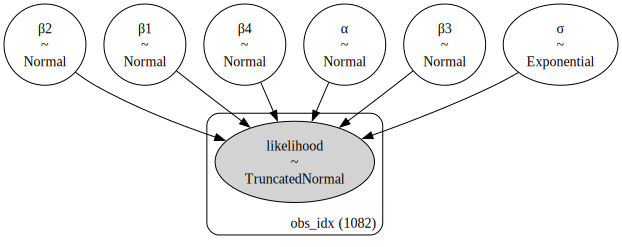

In [209]:
bayes_oc6.to_graphviz()

In [210]:
with bayes_oc6:
    idata_oc6 = pm.sample_prior_predictive()

Sampling: [likelihood, α, β1, β2, β3, β4, σ]


array([<Axes: xlabel='likelihood'>], dtype=object)

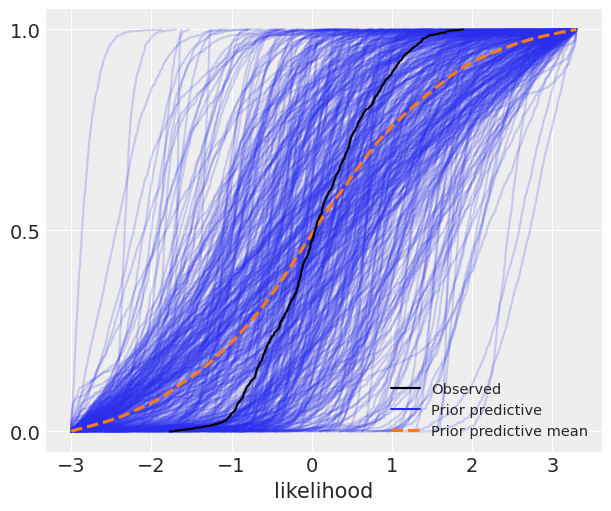

In [211]:
f, ax = pp.subplots(figsize=(6,5))
az.plot_ppc(idata_oc6, kind= 'cumulative', group='prior', ax=ax, observed=True, )

In [212]:
with bayes_oc6:
    idata_oc6.extend(pm.sample(2000, chains=4))
    

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, β2, β3, β4, σ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_67001/2668462343.py:3: UserWarning: The figure layout has changed to tight
  f.tight_layout()


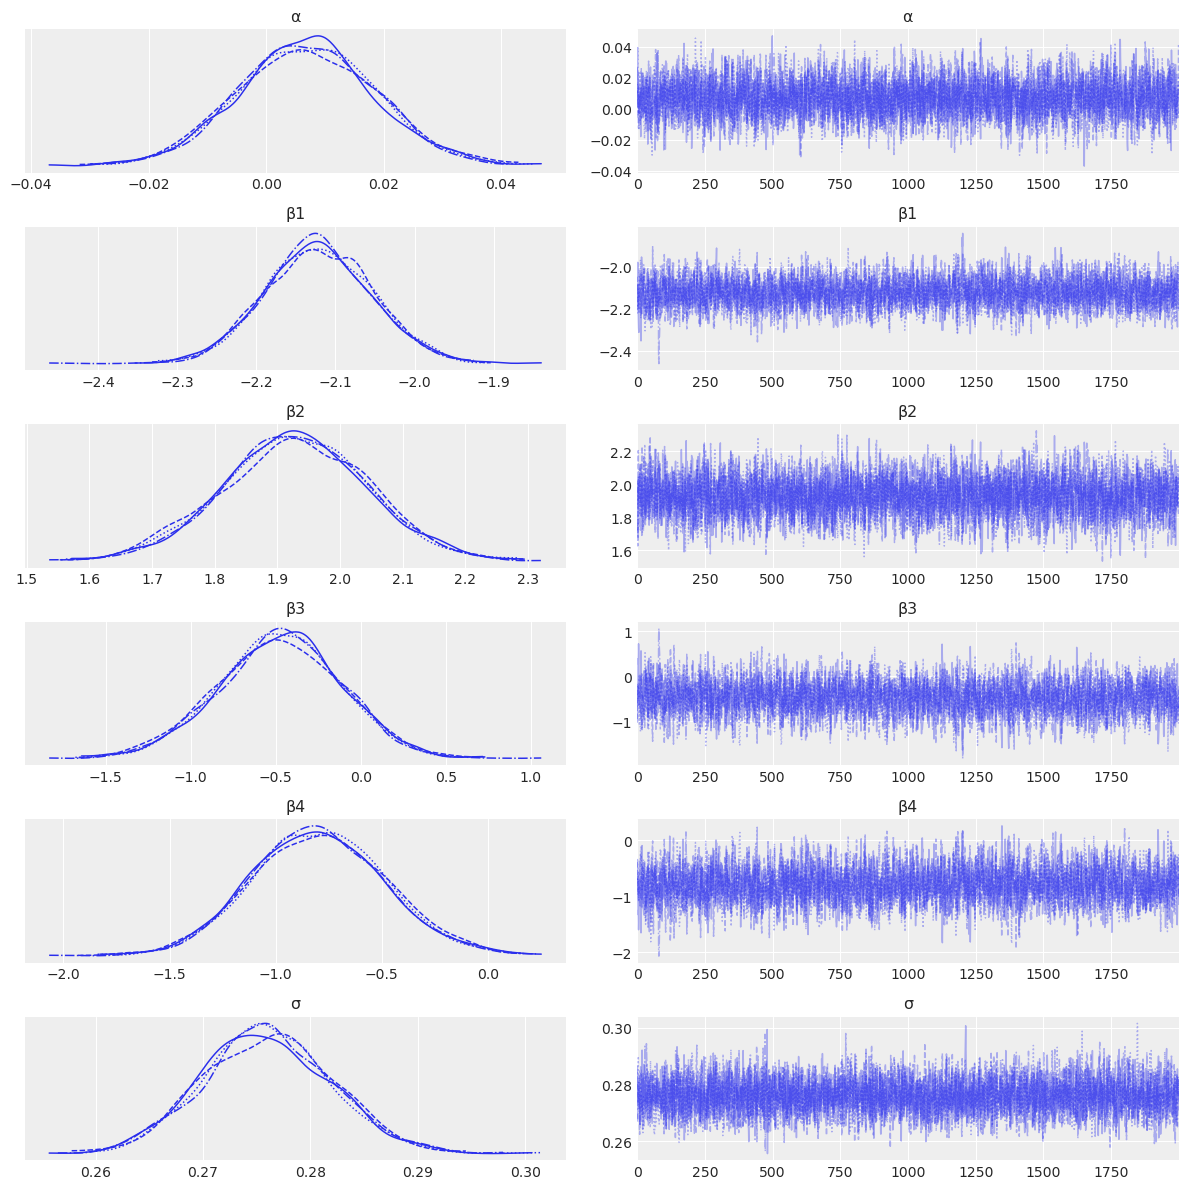

In [213]:
az.plot_trace(idata_oc6);
f = pp.gcf()
f.tight_layout()


In [214]:
with bayes_oc6:
    idata_oc6.extend(pm.sample_posterior_predictive(idata_oc6))

Sampling: [likelihood]


Output()

array([<Axes: xlabel='likelihood'>], dtype=object)

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


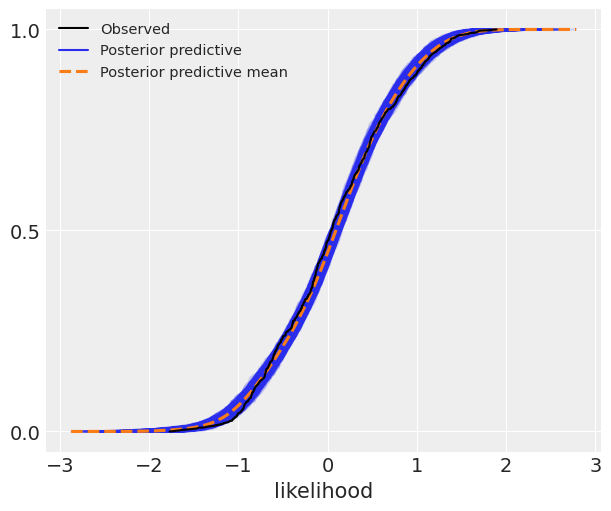

In [215]:
f_postpc, ax = pp.subplots(figsize=(6,5))
az.plot_ppc(idata_oc6, kind='cumulative', group='posterior', ax=ax)

### 2. Bayesian Hierarchical Partially Pooled Linear Max Band Ratio Model, 4 and 6 band groups


Here we start similarly to Gordon et al (1983) but use an approach that circumvents discontinuities reported from switching between blue bands. Thus:
* We compute Max Band Ratio (MBR) as in our Bayesian OC6 model; 
    * the numerator is the maximum of Rrs411, Rrs443, Rrs489, Rrs510,
    * the denomiator is the sum of Rrs555 and Rrs670
    * we track the band used in numerator by adding a "MBR_flag" in our data 
* We segregate the data into 4 groups, each corresponding to the MBR numerator.
* We use a hierarchical partially pooled formulation to:
    * Take advantage of the group structure in the data
    * Maximize the use of the available data (see below)
    * Each group receives its own model slope and intercept parameters
    * These parameters have common hyperpriors (see model graph below)
        * Hyperpriors enabl the sharing of information between groups as the model is being fit
    

#### Explanation - Grouping by Spectral Dominance in Hierarchical Modeling

An expanded version of the grouping approach considers the maximum Rrs value across all key spectral bands—blue, green, and red—to define group membership. This method reflects the dominant optical signal in each observation, which often corresponds to different water types or biogeophysical regimes:

* **Rrs$\_{411}\$-dominant**: Typically associated with ultra-clear, oligotrophic waters. High reflectance at this wavelength implies minimal absorption by both phytoplankton and CDOM, suggesting extremely low pigment concentration and low scattering.
* **Rrs$\_{443}\$-dominant**: Often found in moderately clear Case-1 waters where phytoplankton absorption is just beginning to affect the spectrum. This group may indicate the presence of picoplankton or lightly productive systems.
* **Rrs$\_{489}\$-dominant**: Represents more productive Case-1 waters with moderate phytoplankton biomass. Reflectance here implies a stronger blue signal retained due to a balance of absorption and scattering.
* **Rrs$\_{510}\$-dominant**: Reflects water with increasing influence from particulate scattering, often signaling turbid phytoplankton-rich environments or transitions to Case-2 water.

Using this expanded spectral dominance scheme as a hierarchical grouping variable enables the model to learn distinct relationships between the empirical index and chlorophyll concentration that correspond to different optical regimes. Even if there is overlap in the scatter of individual data points across groups, systematic differences in slope or intercept—common across these spectral classes—justify the use of group-specific structure.

In [ ]:
X = df_training.log_MBR
y = df_training.log_chl
with pm.Model(coords=COORDS) as hl_mbr:
    # Register group index and predictor with obs dimensions
    group_idx = pm.Data(
        'group_idx', mbr_type_idx, dims='obs_idx')
    X_data = pm.Data('X', X.values, dims='obs_idx')
    # ------- Hyper-priors ---------
    α_μ = pm.Normal('α_μ', 0, 1)
    α_σ = pm.Exponential('α_σ', 1)
    β_μ = pm.Normal('β_μ', 0, 1)
    β_σ = pm.Exponential('β_σ', 1)
    # ------- Priors ---------------
    α = pm.Normal('α', α_μ, α_σ, dims='MBR_numerator')
    β = pm.Normal('β', β_μ, β_σ, dims='MBR_numerator')
    σ = pm.Gamma('σ', 2, 2)

    μ = α[group_idx] + β[group_idx] * X_data
    likelihood = pm.TruncatedNormal(
        'likelihood', mu=μ, sigma=σ, lower=-3, upper=3.2, observed=y, dims='obs_idx')


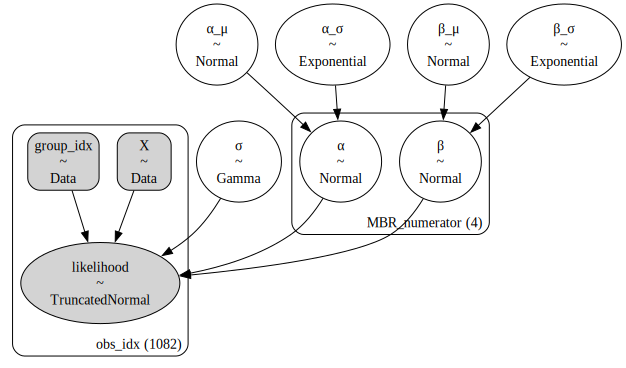

In [128]:
hl_mbr.to_graphviz()

In [129]:
with hl_mbr:
    idata_hlmbr = pm.sample_prior_predictive()

Sampling: [likelihood, α, α_μ, α_σ, β, β_μ, β_σ, σ]


array([<Axes: xlabel='likelihood'>], dtype=object)

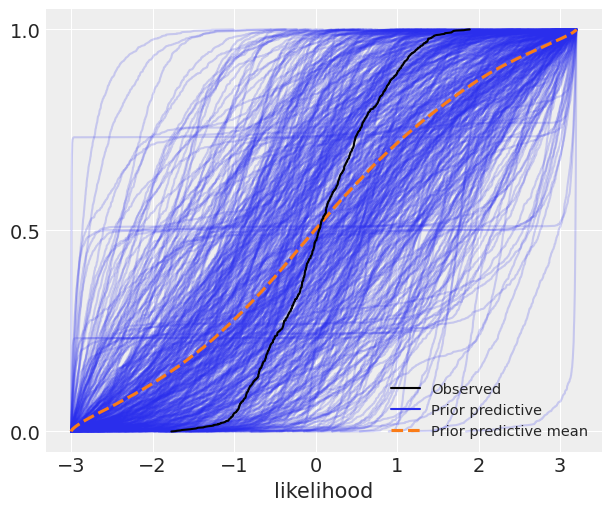

In [130]:
f, ax = pp.subplots(figsize=(6,5))
az.plot_ppc(idata_hlmbr, kind= 'cumulative', group='prior', ax=ax, observed=True)

In [131]:
with hl_mbr:
    idata_hlmbr.extend(pm.sample(2000, chains=4))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.


In [132]:
az.summary(idata_hlmbr).to_clipboard()

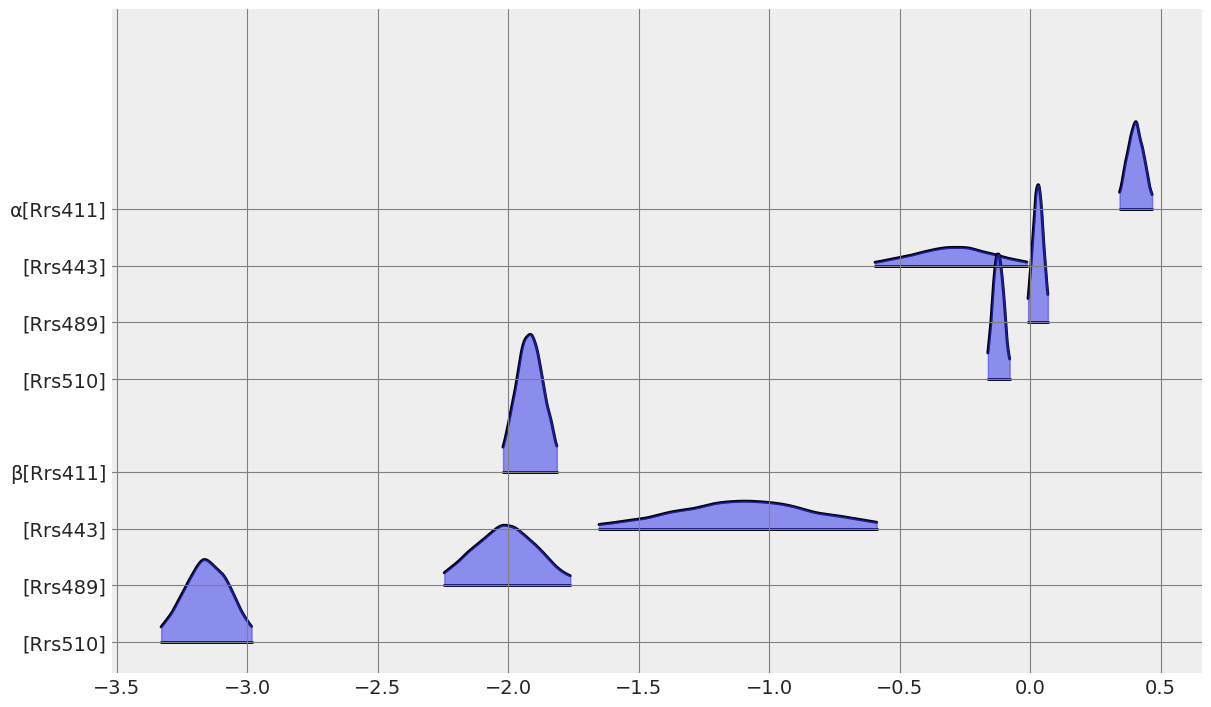

In [133]:
ax = az.plot_forest(
    idata_hlmbr, var_names=['α','β'], kind='ridgeplot', combined=True, 
    textsize=20,
    ridgeplot_alpha=0.5)[0]
ax.grid(color='gray')
f_forest_hlmbr = pp.gcf()
#f_forest_hlmbr.tight_layout()

In [134]:
with hl_mbr:
    idata_hlmbr.extend(pm.sample_posterior_predictive(idata_hlmbr))

Sampling: [likelihood]


Output()

array([<Axes: xlabel='likelihood'>], dtype=object)

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


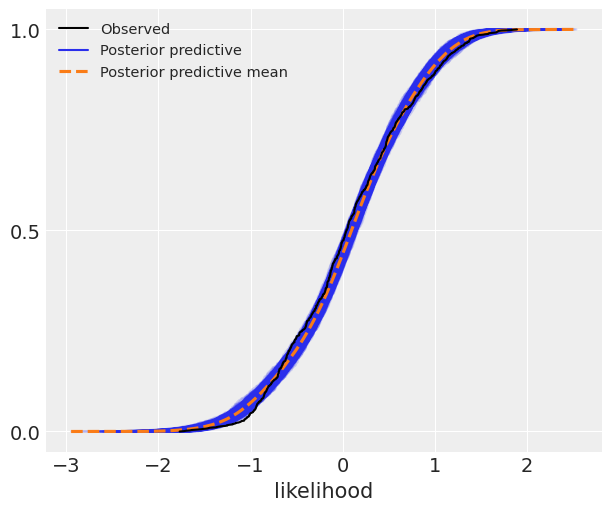

In [135]:
f_hlmbr_postpc, ax = pp.subplots(figsize=(6,5))
az.plot_ppc(idata_hlmbr, kind='cumulative', group='posterior', ax=ax)

/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_67001/2798706240.py:45: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


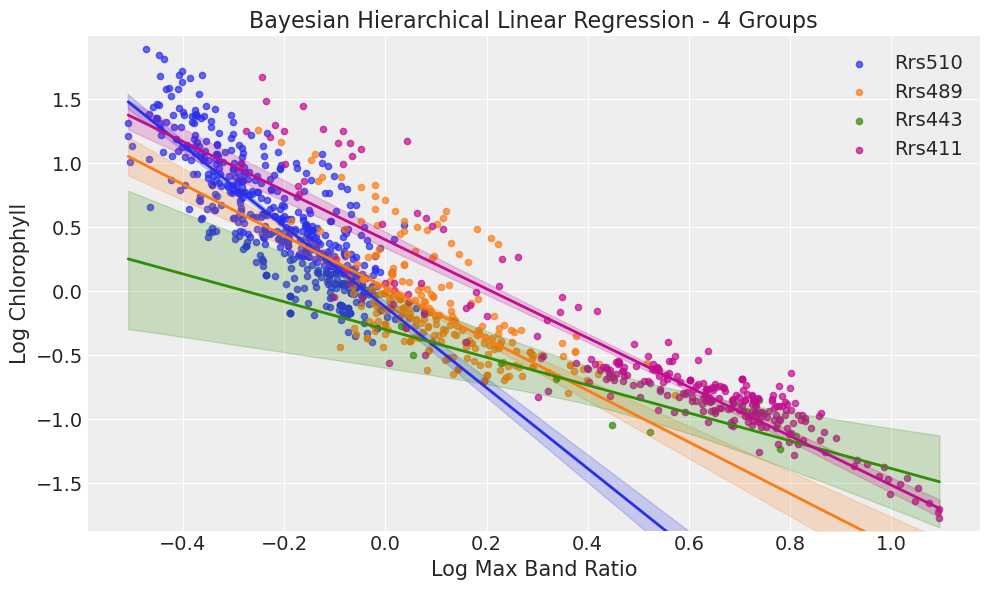

In [ ]:
# Get the unique group names from your data (should match coordinates in idata_hlmbr)
groups = df['MBR_flag'].unique()

# --- Plotting ---

fig, ax = pp.subplots(figsize=(10, 6))

# 1. Scatter Plot of Data Points
for group in groups:
    group_data = df[df['MBR_flag'] == group]
    ax.scatter(
        group_data['log_MBR'],
        group_data['log_chl'],
        label=group,
        alpha=0.7,
        s=20
    )

# 2. Regression Lines with Uncertainty
x_range = np.linspace(df['log_MBR'].min(), df['log_MBR'].max(), 100)

for i, group_name in enumerate(groups):
    # Select posterior samples using the correct coordinate name 'MBR_numerator'
    alpha_posterior = idata_hlmbr.posterior['α'].sel(MBR_numerator=group_name).values.flatten()
    beta_posterior = idata_hlmbr.posterior['β'].sel(MBR_numerator=group_name).values.flatten()

    # Generate regression lines for each sample
    regression_lines = np.outer(beta_posterior, x_range) + alpha_posterior[:, np.newaxis]

    # Plot the mean regression line
    ax.plot(x_range, regression_lines.mean(axis=0), color=f'C{i}', linewidth=2)

    # Plot the uncertainty (e.g., 94% HDI)
    hdi_lower = np.percentile(regression_lines, 3, axis=0)
    hdi_upper = np.percentile(regression_lines, 97, axis=0)
    ax.fill_between(x_range, hdi_lower, hdi_upper, color=f'C{i}', alpha=0.2)

# 3. Labels and Legend
ax.set_ylim(df.log_chl.min()-0.1, df.log_chl.max()+0.1)
ax.set_xlabel('Log Max Band Ratio')
ax.set_ylabel('Log Chlorophyll')
ax.set_title('Bayesian Hierarchical Linear Regression - 4 Groups')
ax.legend()
ax.grid(True)
fig.tight_layout()

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hd

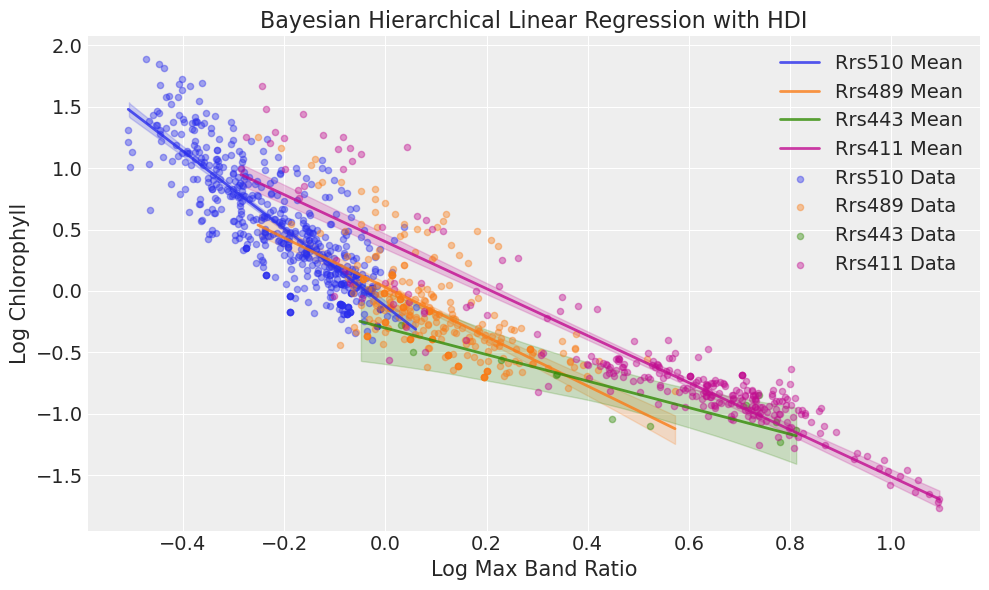

In [120]:
# Define the x-range for the regression lines
x_range = np.linspace(df['log_MBR'].min(), df['log_MBR'].max(), 100)

fig, ax = pp.subplots(figsize=(10, 6))

for i, group_name in enumerate(groups):

    # Get posterior samples for the current group's alpha and beta
    alpha_posterior = idata_hlmbr.posterior['α'].sel(MBR_numerator=group_name).values.flatten()
    beta_posterior = idata_hlmbr.posterior['β'].sel(MBR_numerator=group_name).values.flatten()
    
    x_range = np.linspace(
        df.loc[df.MBR_flag==group_name, 'log_MBR'].min(), 
        df.loc[df.MBR_flag==group_name, 'log_MBR'].max(), 100)
    # Generate regression lines for each posterior sample
    regression_lines = alpha_posterior[:, np.newaxis] + beta_posterior[:, np.newaxis] * x_range

    # Plot the HDI of the regression lines
    az.plot_hdi(x_range, regression_lines, ax=ax, color=f'C{i}', hdi_prob=0.94,  fill_kwargs={'alpha': 0.2})

    # Plot the mean regression line on top
    mean_alpha = alpha_posterior.mean()
    mean_beta = beta_posterior.mean()
    ax.plot(x_range, mean_alpha + mean_beta * x_range, color=f'C{i}', linewidth=2, label=f'{group_name} Mean', alpha=0.8)

# Scatter plot of the original data (optional, but helpful for context)
for group in groups:
    group_data = df[df['MBR_flag'] == group]
    ax.scatter(
        group_data['log_MBR'],
        group_data['log_chl'],
        label=f'{group} Data',
        alpha=0.4,
        s=20
    )

# Labels and Legend
ax.set_xlabel('Log Max Band Ratio')
ax.set_ylabel('Log Chlorophyll')
ax.set_title('Bayesian Hierarchical Linear Regression with HDI')
ax.legend()
ax.grid(True)
fig.tight_layout()

### 3. Extending the grouping to all bands:

#### Grouping by Spectral Dominance in Hierarchical Modeling

An expanded version of the grouping approach considers the maximum Rrs value across all key spectral bands—blue, green, and red—to define group membership. This method reflects the dominant optical signal in each observation, which often corresponds to different water types or biogeophysical regimes:

*  $Rrs555$ - **dominant**: Green-dominant spectra are typically found in high biomass or sediment-rich waters. This group often indicates substantial backscatter, either from large phytoplankton or inorganic particles.
* $Rrs670$ - **dominant**: Extremely rare but potentially indicative of intense algal blooms or red-dominated turbid waters. Elevated $Rrs670$ typically occurs only when backscatter is exceptionally high, and may also reflect chlorophyll fluorescence peaks.

In [60]:
mbr_type_idx, mbr_type = df_training.MBR_flag.factorize(sort=True)
spectral_type_idx, spectral_type = df_training.max_band_all_flag.factorize(sort=True)
chl_type_idx, chl_type = df_training.hplc_flag.factorize(sort=True)
COORDS = {
    'MBR_numerator': mbr_type,
    'spectral_type': spectral_type,
    'chl_type': chl_type,
    'obs_idx': df_training.index
}

In [35]:
X = df_training.log_MBR
y = df_training.log_chl
with pm.Model(coords=COORDS) as hl_mbr_6gps:
    # Register group index and predictor with obs dimensions
    spectral_group_idx = pm.Data('spectral_group_idx', spectral_type_idx, dims='obs_idx')
    X_data = pm.Data('X', X.values, dims='obs_idx')
    # ------- Hyper-priors ---------
    α_μ = pm.Normal('α_μ', 0, 1)
    α_σ = pm.Exponential('α_σ', 1)
    β_μ = pm.Normal('β_μ', 0, 1)
    β_σ = pm.Exponential('β_σ', 1)
    # ------- Priors ---------------
    α = pm.Normal('α', α_μ, α_σ, dims='spectral_type')
    β = pm.Normal('β', β_μ, β_σ, dims='spectral_type')
    σ = pm.Gamma('σ', 2, 2)

    μ = α[spectral_group_idx] + β[spectral_group_idx] * X_data
    likelihood = pm.TruncatedNormal(
        'likelihood', mu=μ, sigma=σ, lower=-3, upper=3.2, observed=y, dims='obs_idx')

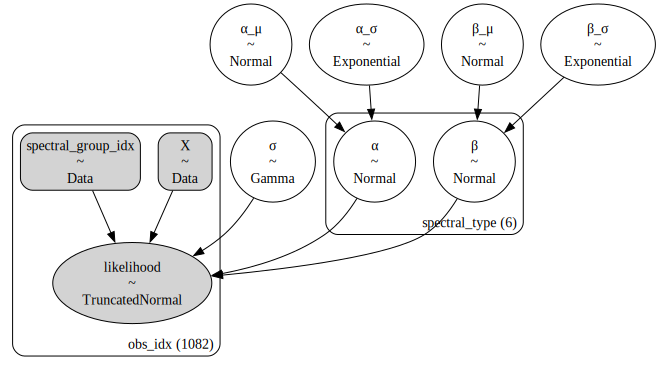

In [36]:
hl_mbr_6gps.to_graphviz()

In [98]:
with hl_mbr_6gps:
    idata_6gps = pm.sample_prior_predictive()

Sampling: [likelihood, α, α_μ, α_σ, β, β_μ, β_σ, σ]


array([<Axes: xlabel='likelihood'>], dtype=object)

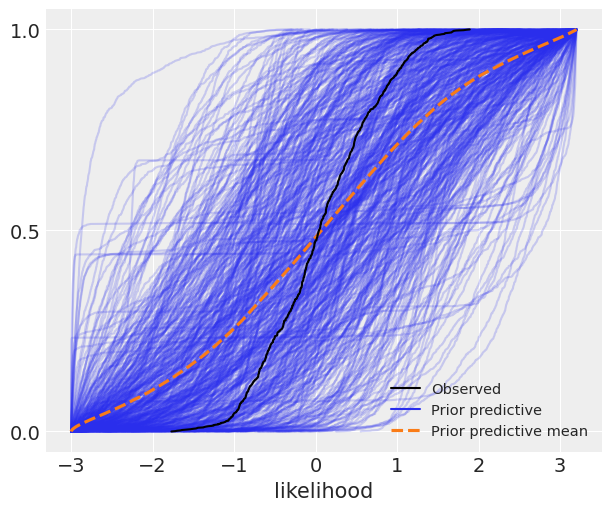

In [99]:
f, ax = pp.subplots(figsize=(6,5))
az.plot_ppc(idata_6gps, kind= 'cumulative', group='prior', ax=ax, observed=True)

In [100]:
with hl_mbr_6gps:
    idata_6gps.extend(pm.sample(2000, chains=4))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.


/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_67001/3503679421.py:3: UserWarning: The figure layout has changed to tight
  f_trace.tight_layout()


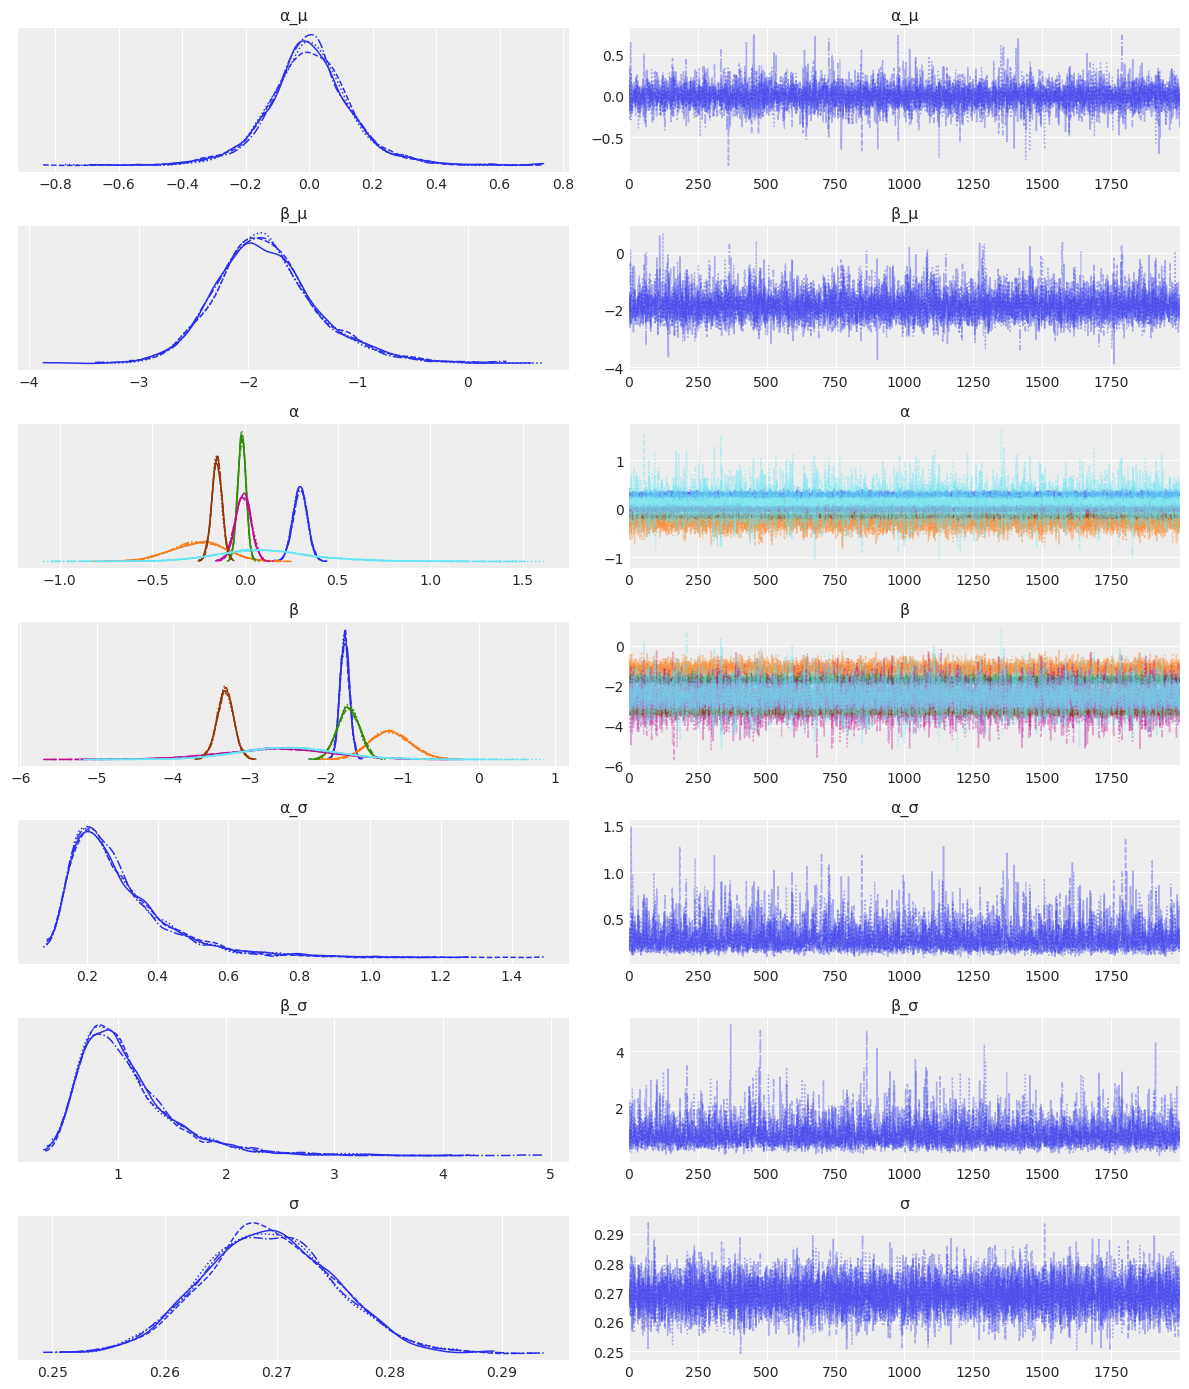

In [101]:
az.plot_trace(idata_6gps)
f_trace = pp.gcf()
f_trace.tight_layout()

In [110]:
az.summary(idata_6gps, var_names=['α', 'β'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
α[Rrs411]  0.297  0.038   0.228    0.371      0.000    0.000    9205.0   
α[Rrs443] -0.253  0.144  -0.522    0.016      0.002    0.002    8070.0   
α[Rrs489] -0.017  0.022  -0.059    0.025      0.000    0.000   11547.0   
α[Rrs510] -0.011  0.042  -0.086    0.071      0.000    0.000    8360.0   
α[Rrs555] -0.153  0.028  -0.208   -0.101      0.000    0.000    8009.0   
α[Rrs670]  0.115  0.278  -0.408    0.638      0.003    0.004    7213.0   
β[Rrs411] -1.755  0.063  -1.878   -1.642      0.001    0.001    9284.0   
β[Rrs443] -1.161  0.264  -1.643   -0.655      0.003    0.003    7551.0   
β[Rrs489] -1.706  0.141  -1.967   -1.440      0.001    0.002   11085.0   
β[Rrs510] -2.656  0.717  -4.038   -1.328      0.008    0.008    9043.0   
β[Rrs555] -3.318  0.111  -3.531   -3.106      0.001    0.001    7942.0   
β[Rrs670] -2.494  0.664  -3.811   -1.298      0.008    0.009    7513.0   

           ess_tail  r_hat  
α[Rrs411]    5528.0    1.0  
α[Rrs443]    6172.0    1.0  
α[Rrs489]    6193.0    1.0  
α[Rrs510]    6341.0    1.0  
α[Rrs555]    6259.0    1.0  
α[Rrs670]    5059.0    1.0  
β[Rrs411]    5955.0    1.0  
β[Rrs443]    6136.0    1.0  
β[Rrs489]    6052.0    1.0  
β[Rrs510]    6441.0    1.0  
β[Rrs555]    5604.0    1.0  
β[Rrs670]    5548.0    1.0

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

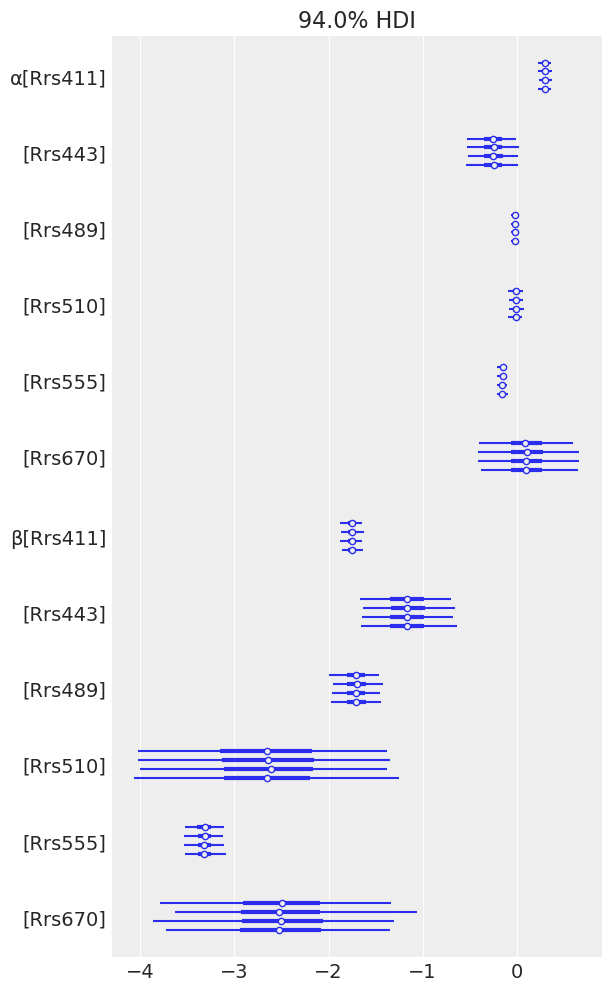

In [107]:
az.plot_forest(idata_6gps, var_names=['α', 'β'])

In [102]:
with hl_mbr_6gps:
    idata_6gps.extend(pm.sample_posterior_predictive(idata_6gps))

Sampling: [likelihood]


Output()

array([<Axes: xlabel='likelihood'>], dtype=object)

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


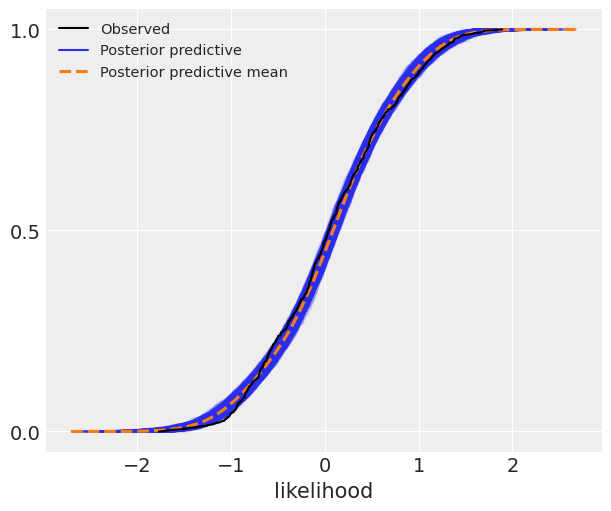

In [103]:
f_hlmbr_6gps_postpc, ax = pp.subplots(figsize=(6,5))
az.plot_ppc(idata_6gps, kind='cumulative', group='posterior', ax=ax)

### 4. Hierarchical Partial Pooling Model with Group-Wise Noise (σ) Term
Noticing that the data seems noisier depending on Maximum Band used for the MBR numerator, I use partial pooling for the noise term resulting in a σ for of the 4 Band ratio group. 

In [153]:
X = df_training.log_MBR
y = df_training.log_chl
with pm.Model(coords=COORDS) as hl_mbr_het:
    # Register group index and predictor with obs dimensions
    group_idx = pm.Data('group_idx', mbr_type_idx, dims='obs_idx')
    X_data = pm.Data('X', X.values, dims='obs_idx')
    # ------- Hyper-priors ---------
    α_μ = pm.Normal('α_μ', 0, 1)
    α_σ = pm.Exponential('α_σ', 1)
    β_μ = pm.Normal('β_μ', 0, 1)
    β_σ = pm.Exponential('β_σ', 1)
    σ_γ = pm.Exponential('σ_γ', 1)
    σ_φ = pm.Exponential('σ_φ', 1)

    # ------- Priors ---------------
    α = pm.Normal('α', α_μ, α_σ, dims='MBR_numerator')
    β = pm.Normal('β', β_μ, β_σ, dims='MBR_numerator')
    
    σ_ = pm.Gamma('σ', σ_γ, σ_φ, dims='MBR_numerator')
    μ = α[group_idx] + β[group_idx] * X_data
    σ = σ_[group_idx]
    likelihood = pm.TruncatedNormal(
        'likelihood', mu=μ, sigma=σ, lower=-3, upper=3.2, observed=y, dims='obs_idx')


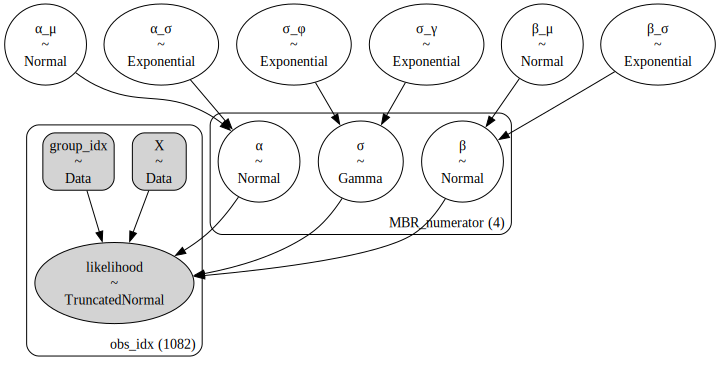

In [154]:
hl_mbr_het.to_graphviz()

In [155]:
with hl_mbr_het:
    idata_hlmbr_het = pm.sample_prior_predictive()

Sampling: [likelihood, α, α_μ, α_σ, β, β_μ, β_σ, σ, σ_γ, σ_φ]
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/pymc/distributions/continuous.py:547: RuntimeWarning: divide by zero encountered in divide
  a=((lower - mu) / sigma).astype("float64"),
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/pymc/distributions/continuous.py:548: RuntimeWarning: divide by zero encountered in divide
  b=((upper - mu) / sigma).astype("float64"),


array([<Axes: xlabel='likelihood'>], dtype=object)

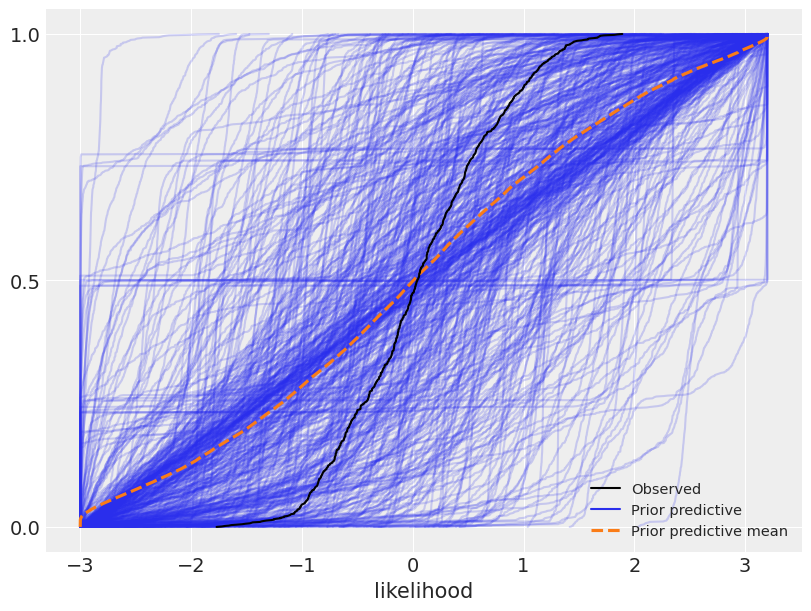

In [159]:
fpr4, ax = pp.subplots(figsize=(8, 6))
az.plot_ppc(idata_hlmbr_het, group='prior', observed=True, ax=ax, kind='cumulative')

In [160]:
with hl_mbr_het:
    idata_hlmbr_het.extend(pm.sample(draws=2000, chains=4))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, σ_γ, σ_φ, α, β, σ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.


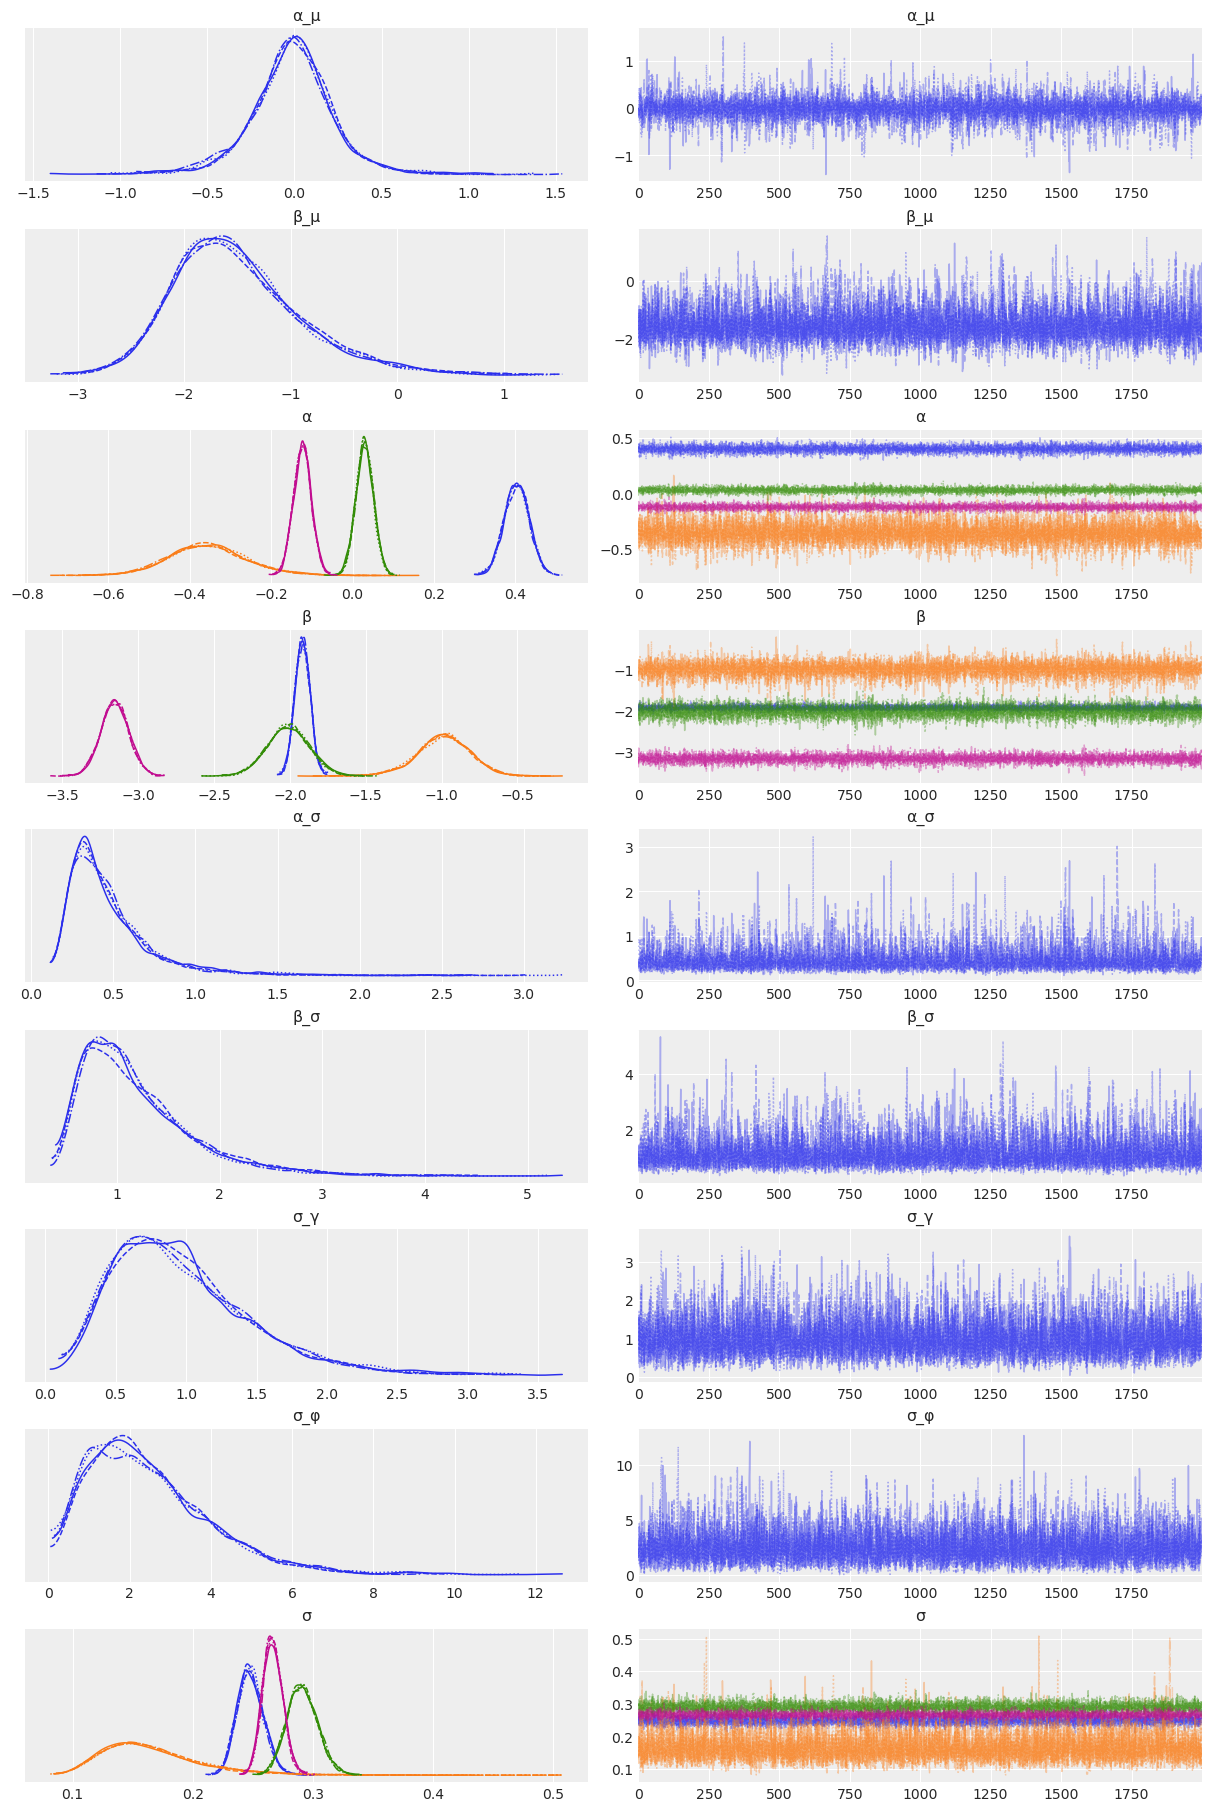

In [218]:
axes = az.plot_trace(idata_hlmbr_het )


In [161]:
with hl_mbr_het:
    idata_hlmbr_het.extend(pm.sample_posterior_predictive(idata_hlmbr_het))

Sampling: [likelihood]


Output()

<Axes: xlabel='likelihood'>

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


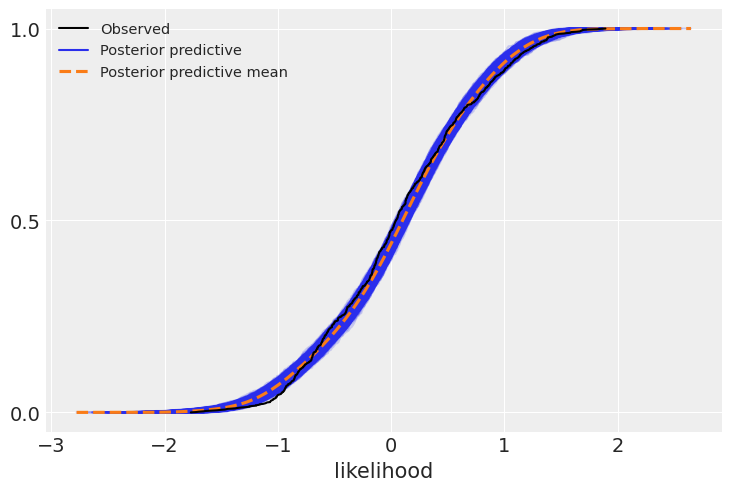

In [182]:
az.plot_ppc(idata_hlmbr_het, kind='cumulative')

### 5. Hierarchical Partiall Pooling Linear Model with Linear Heteroscedasticity\



In [263]:
X = df_training.log_MBR
y = df_training.log_chl
with pm.Model(coords=COORDS) as hl_mbr_lin_het:
    # Register group index and predictor with obs dimensions
    group_idx = pm.Data('group_idx', mbr_type_idx, dims='obs_idx')
    X_data = pm.Data('X', X.values, dims='obs_idx')
    # ------- Hyper-priors ---------
    α_μ = pm.Normal('α_μ', 0, 1)
    α_σ = pm.Exponential('α_σ', 1)
    β_μ = pm.Normal('β_μ', 0, 1)
    β_σ = pm.Exponential('β_σ', 1)

    # ------- Priors ---------------
    α = pm.Normal('α', α_μ, α_σ, dims='MBR_numerator')
    β = pm.Normal('β', β_μ, β_σ, dims='MBR_numerator')
    σ_α = pm.Normal('σ_α', 0, 1)
    σ_β = pm.Normal('σ_β', 0, 1)
   
    μ = α[group_idx] + β[group_idx] * X_data
    log_σ = σ_α + σ_β * X_data
    σ = pm.Deterministic('σ', pm.math.exp(log_σ))
    likelihood = pm.TruncatedNormal(
        'likelihood', mu=μ, sigma=σ, lower=-3, upper=3.2, observed=y, dims='obs_idx')

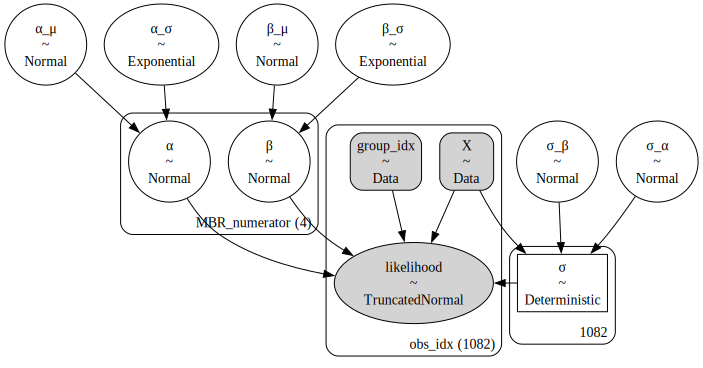

In [264]:
hl_mbr_lin_het.to_graphviz()

In [265]:
with hl_mbr_lin_het:
    idata_hlmbr_lin_het = pm.sample_prior_predictive()

Sampling: [likelihood, α, α_μ, α_σ, β, β_μ, β_σ, σ_α, σ_β]


<Axes: xlabel='likelihood'>

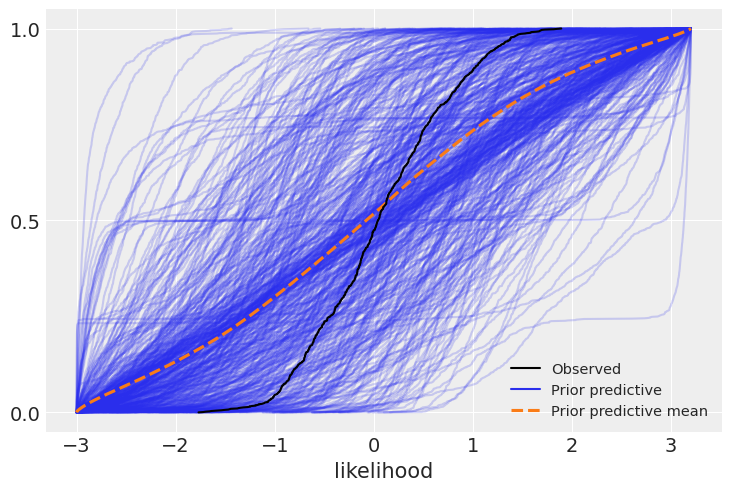

In [267]:
az.plot_ppc(idata_hlmbr_lin_het, group='prior', observed=True, kind='cumulative')

In [268]:
with hl_mbr_lin_het:
    idata_hlmbr_lin_het.extend(pm.sample(draws=2000, chains=4))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, α, β, σ_α, σ_β]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


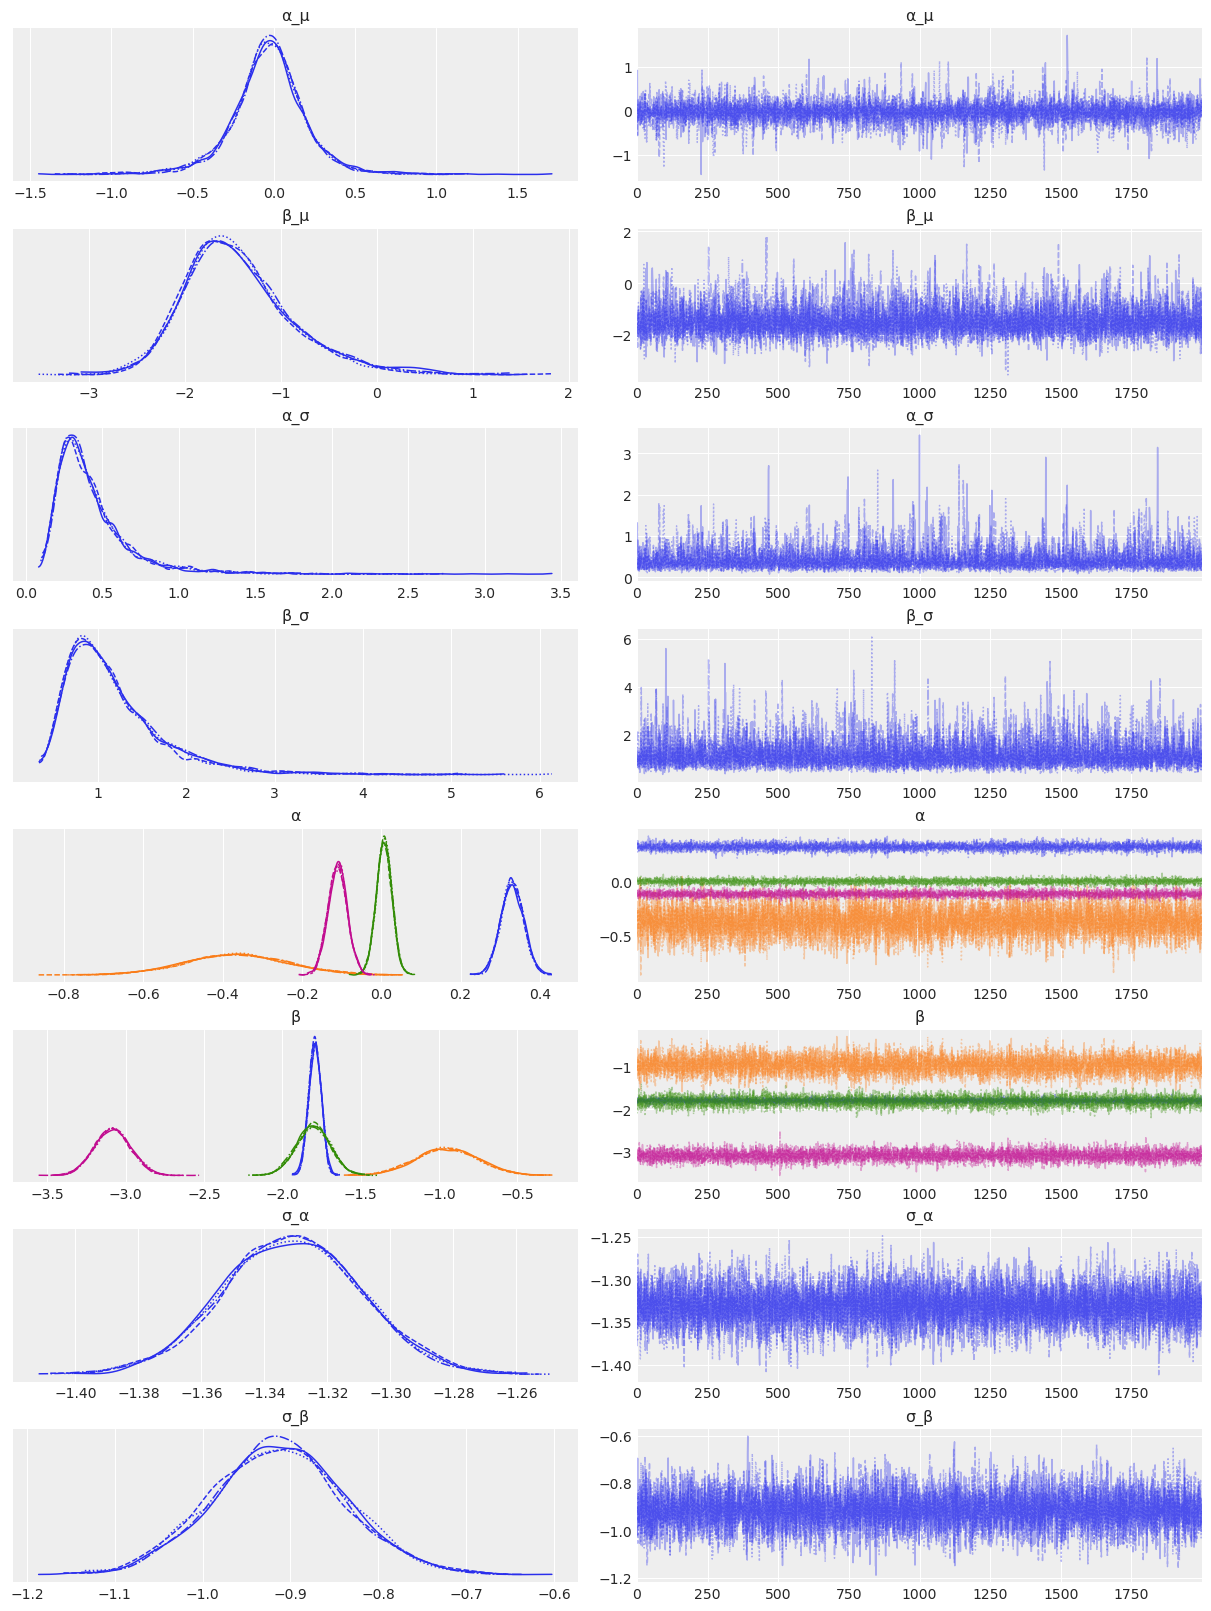

In [273]:
axes = az.plot_trace(
    idata_hlmbr_lin_het, var_names=[
        'α_μ', 'β_μ', 'α_σ', 'β_σ', 'α', 'β', 'σ_α', 'σ_β'])

In [270]:
with hl_mbr_lin_het:
    idata_hlmbr_lin_het.extend(pm.sample_posterior_predictive(idata_hlmbr_lin_het))

Sampling: [likelihood]


Output()

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


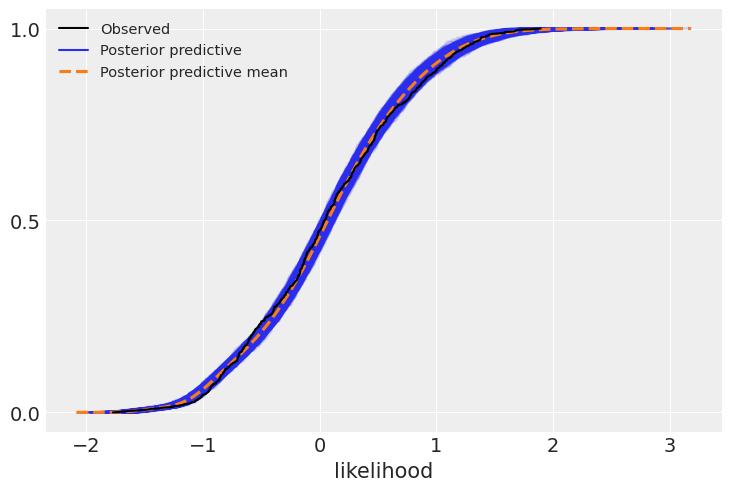

In [272]:
axes = az.plot_ppc(idata_hlmbr_lin_het, kind='cumulative')

In [ ]:
X = df_training.log_MBR
y = df_training.log_chl
with pm.Model(coords=COORDS) as hl_mbr_het:
    # Register group index and predictor with obs dimensions
    group_idx = pm.Data('group_idx', mbr_type_idx, dims='obs_idx')
    X_data = pm.Data('X', X.values, dims='obs_idx')
    # ------- Hyper-priors ---------
    α_μ = pm.Normal('α_μ', 0, 1)
    α_σ = pm.Exponential('α_σ', 1)
    β_μ = pm.Normal('β_μ', 0, 1)
    β_σ = pm.Exponential('β_σ', 1)
    σ_α_μ = pm.Normal('σ_α_μ', 0, 1)
    σ_α_σ = pm.Exponential('σ_α_σ', 1)
    σ_β_μ = pm.Normal('σ_β_μ', 0, 1)
    σ_β_σ = pm.Exponential('σ_β_σ', 1)

    # ------- Priors ---------------
    α = pm.Normal('α', α_μ, α_σ, dims='MBR_numerator')
    β = pm.Normal('β', β_μ, β_σ, dims='MBR_numerator')
    σ_α = pm.Normal('σ_α', σ_α_μ, σ_α_σ, dims='MBR_numerator')
    σ_β = pm.Normal('σ_β', σ_β_μ, σ_β_σ, dims='MBR_numerator')
    
    σ_ = pm.Gamma('σ', σ_γ, σ_φ, dims='MBR_numerator')
    μ = α[group_idx] + β[group_idx] * X_data
    log_σ = σ_α[group_idx] + σ_β[group_idx] * X_data
    σ = pm.Deterministic('σ', pm.math.exp(log_σ))
    likelihood = pm.TruncatedNormal(
        'likelihood', mu=μ, sigma=σ, lower=-3, upper=3.2, observed=y, dims='obs_idx')

0.001

# A Primer on Bayesian Model Comparison: WAIC vs. LOO (and Alternatives)
When comparing Bayesian regression models – such as polynomial regressions, hierarchical partial pooling models, or more complex machine-learning models like BART (Bayesian Additive Regression Trees) – we need techniques that account for both model fit and complexity. All these models have the same likelihood;  a truncated normal $N(\mu,\sigma)$ constrained on the $log(Chl a)$ scale to $[-3, 3.2]$ corresponding to pigment concentrations with $0.001 - 1500 mg\ m^{-3}$, to insure model outputs are realistic. The truncated normal likelihood has mean $\mu$ given by the regression and $\sigma$ a noise scale. Beyond this likelihood formulation, models differ in how $\mu$ (and possibly $\sigma$ when heteroscedasticity is assumed) are expressed.

Bayesian model comparison focuses on predictive performance and model evidence, rather than just point estimates. Two popular approaches are the Watanabe–Akaike Information Criterion (WAIC) and Leave-One-Out cross-validation (LOO). We will briefly explain the assumptions and math behind WAIC and LOO, how to use them for Bayesian model selection, and how to implement them in practice (in the present study with the PyMC and ArviZ Python libraries). We’ll also discuss alternative techniques (marginal likelihood/Bayes factors, cross-validation variants, etc.), highlighting strengths and limitations for models that share a likelihood but have differing priors or structures.

## WAIC: Watanabe–Akaike Information Criterion
WAIC (sometimes called Widely Applicable Information Criterion) is a fully Bayesian generalization of classical AIC. WAIC estimates the out-of-sample deviance (or equivalently, expected log predictive density) for a fitted model by using the entire posterior distribution. The key idea is to evaluate how well the model predicts each data point when that data point is treated as new, averaging over the uncertainty in the model parameters. Formally, if $p(y_i \mid \theta)$ is the likelihood for data point $i$ given parameters $\theta$, and we have $S$ posterior draws ${\theta^s}_{s=1}^S$, then the pointwise log predictive density for $y_i$ can be estimated as:

$$ \widehat{\log p(y_i \mid \text{model})} \approx \log \frac{1}{S}\sum_{s=1}^S p(y_i \mid \theta^s) \tag{1} $$

WAIC then adjusts this for model complexity by computing the effective number of parameters $p_{\text{WAIC}}$; the sum of the posterior variances of the log-likelihood for each data point:

$$ p_{\text{WAIC}} = \sum_{i=1}^n \text{Var}_{\theta\sim p(\theta \mid D)}[\log p(y_i \mid \theta)] \tag{2} $$

### Appendix - Formulae used for Bayesian Model Comparison:

1. **Pointwise Log Predictive Density**  
   $$ \widehat{\log p(y_i \mid \text{model})} \approx \log \frac{1}{S}\sum_{s=1}^S p(y_i \mid \theta^s) \tag{1} $$

2. **Effective Number of Parameters (for WAIC)**  
   $$ p_{\text{WAIC}} = \sum_{i=1}^n \text{Var}_{\theta\sim p(\theta \mid D)}[\log p(y_i \mid \theta)] \tag{2} $$

3. **WAIC Score (Deviance Scale)**  
   $$ \text{WAIC} = -2 \left( \sum_{i=1}^n \log \frac{1}{S}\sum_{s=1}^S p(y_i \mid \theta^s) - p_{\text{WAIC}} \right) \tag{3} $$

4. **Leave-One-Out Cross-Validation (LOO ELPD)**  
   $$ \text{ELPD}_{\text{LOO}} = \sum_{i=1}^n \log p(y_i \mid y_{-i}, M) \tag{4} $$

5. **Approximation to LOO Log Score Using PSIS**  
   $$ \widehat{\log p(y_i \mid y_{-i}, M)} \approx \log \left( \frac{\sum_{s=1}^S w_{is} p(y_i \mid \theta^s)}{\sum_{s=1}^S w_{is}} \right), \quad \text{where} \quad w_{is} = \frac{1}{p(y_i \mid \theta^s)} \tag{5} $$

6. **Bayes Factor**  
   $$ \text{Bayes Factor} = \frac{p(D \mid M_1)}{p(D \mid M_2)} \tag{6} $$

7. **DIC (Deviance Information Criterion)**  
   $$ \text{DIC} = \bar{D} + p_D, \quad \text{where} \quad \bar{D} = -2 \log p(D \mid \theta), \quad p_D = \bar{D} - D(\bar{\theta}) \tag{7} $$

8. **Stacking (Predictive Distribution Weights)**  
   $$ p(y_i \mid M) = \sum_{m=1}^M w_m p(y_i \mid M_m) \tag{8} $$  
   where $w_m$ are the model weights optimized by maximizing predictive accuracy.


## Model Comparison

#### 1. Uncertainty of Model Mean

/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_67001/1267459112.py:6: UserWarning: The figure layout has changed to tight
  f.tight_layout()


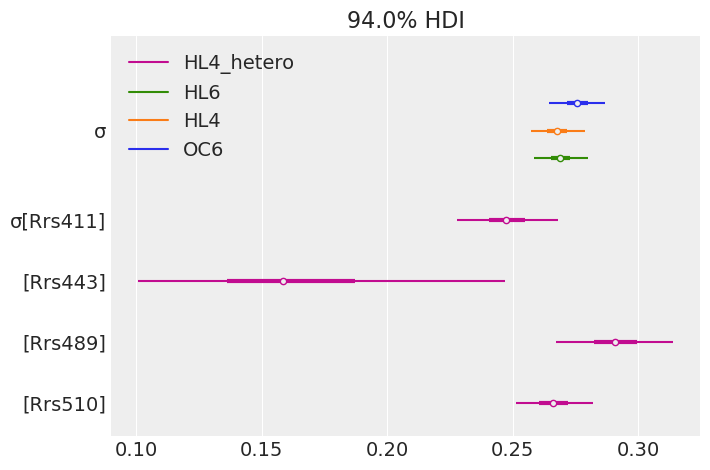

In [250]:
f, ax = pp.subplots()
az.plot_forest(
    [idata_oc6, idata_hlmbr, idata_6gps, idata_hlmbr_het], 
    model_names=['OC6', 'HL4', 'HL6', 'HL4_hetero'],
    var_names='σ', combined=True, ax=ax)
f.tight_layout()


Text(0.5, 1.0, 'Intercepts -- 94.0% HDI')

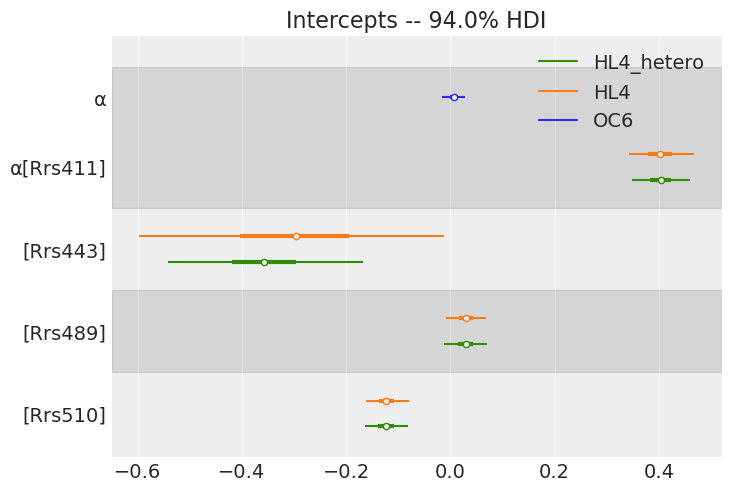

In [222]:
f, ax = pp.subplots()
az.plot_forest(
    [idata_oc6, idata_hlmbr, idata_hlmbr_het], 
    model_names=['OC6','HL4', 'HL4_hetero'],
    var_names='α', combined=True, ax=ax)
ax.set_title('Intercepts -- ' + ax.get_title())

Text(0.5, 1.0, 'Slopes -- 94.0% HDI')

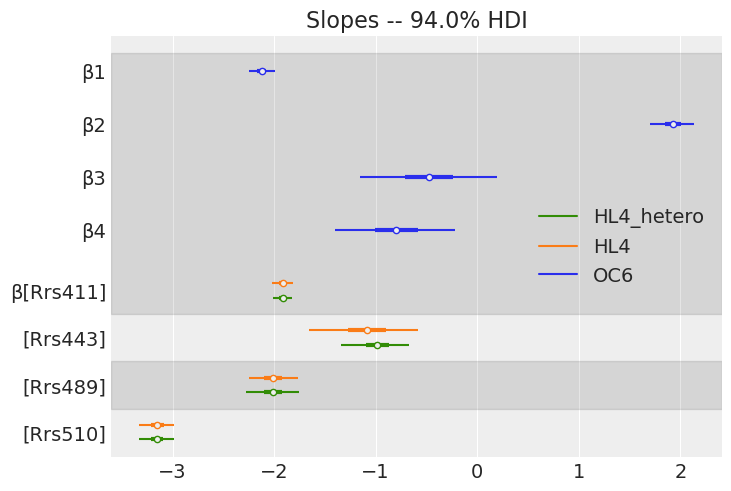

In [221]:
f, ax = pp.subplots()
az.plot_forest(
    [idata_oc6, idata_hlmbr, idata_hlmbr_het], 
    model_names=['OC6','HL4', 'HL4_hetero'],
    var_names=['β1','β2', 'β3', 'β4', 'β'], combined=True, ax=ax)
ax.set_title('Slopes -- ' + ax.get_title())

Text(0.5, 1.0, 'Noise -- 94.0% HDI')

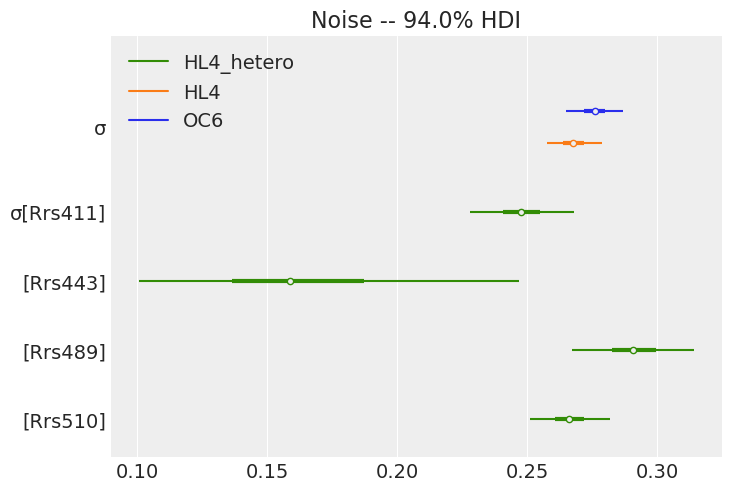

In [223]:
f, ax = pp.subplots()
az.plot_forest(
    [idata_oc6, idata_hlmbr, idata_hlmbr_het], 
    model_names=['OC6','HL4', 'HL4_hetero'],
    var_names='σ', combined=True, ax=ax)
ax.set_title('Noise -- ' + ax.get_title())

In [274]:

with bayes_oc6:
    try:
        _ = pm.compute_log_likelihood(idata_oc6, extend_inferencedata=True)
    except ValueError:
        pass

with hl_mbr:
    try:
        _ = pm.compute_log_likelihood(idata_hlmbr, extend_inferencedata=True)
    except ValueError:
        pass

with hl_mbr_6gps:
    try:
        _ = pm.compute_log_likelihood(idata_6gps, extend_inferencedata=True)
    except ValueError:
        pass

with hl_mbr_het:
    try:
        _ = pm.compute_log_likelihood(idata_hlmbr_het, extend_inferencedata=True)
    except ValueError:
        pass

with hl_mbr_lin_het:
    try:
        _ = pm.compute_log_likelihood(idata_hlmbr_lin_het, extend_inferencedata=True)
    except ValueError:
        pass
   


Output()

Output()

Output()

Output()

Output()

In [275]:
compare_results = az.compare(
    {
        'Bayesian OC6': idata_oc6, 
        'Hierarchical Linear MBR': idata_hlmbr,
        'H. L. MBR w/ 6 Spectral Groups': idata_6gps,
        'H. L. MBR w/ group-wise noise': idata_hlmbr_het,
        'H. L. MBR w/ linear heteroscedasticity': idata_hlmbr_lin_het
        },
    ic='loo'
)

# Print the comparison table
compare_results

rank    elpd_loo      p_loo  \
H. L. MBR w/ linear heteroscedasticity     0  -51.630867  10.772092   
H. L. MBR w/ group-wise noise              1 -111.077653  14.614723   
Hierarchical Linear MBR                    2 -114.069848   9.918126   
H. L. MBR w/ 6 Spectral Groups             3 -120.856512  11.413811   
Bayesian OC6                               4 -144.471253   5.350195   

                                        elpd_diff        weight         se  \
H. L. MBR w/ linear heteroscedasticity   0.000000  8.561452e-01  29.987850   
H. L. MBR w/ group-wise noise           59.446785  1.054922e-10  27.942244   
Hierarchical Linear MBR                 62.438981  1.255596e-10  27.588068   
H. L. MBR w/ 6 Spectral Groups          69.225644  1.289554e-10  29.403303   
Bayesian OC6                            92.840386  1.438548e-01  31.683394   

                                              dse  warning scale  
H. L. MBR w/ linear heteroscedasticity   0.000000    False   log  
H. L. MBR w/ group-wise noise           11.146334    False   log  
Hierarchical Linear MBR                 10.568580    False   log  
H. L. MBR w/ 6 Spectral Groups          12.671050    False   log  
Bayesian OC6                            18.464016    False   log

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

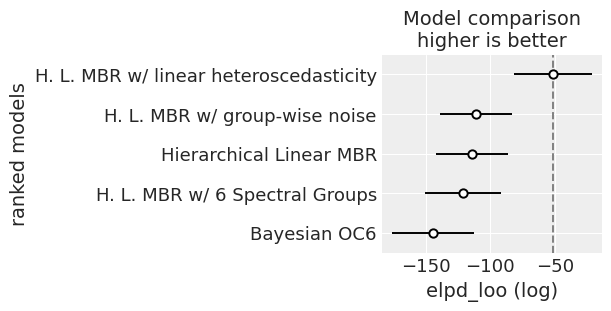

In [276]:
f_comp_loo, ax = pp.subplots(figsize=(6, 3))
az.plot_compare(compare_results, ax=ax)

In [277]:
compare_results_waic = az.compare(
    {
        'Bayesian OC6': idata_oc6, 
        'Hierarchical Linear MBR': idata_hlmbr,
        'H. L. MBR w/ 6 Spectral Groups': idata_6gps,
        'H. L. MBR w/ group-wise noise': idata_hlmbr_het,
        'H. L. MBR w/ linear heteroscedasticity': idata_hlmbr_lin_het
        },
    ic='waic'
)

# Print the comparison table
compare_results_waic

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


rank   elpd_waic     p_waic  \
H. L. MBR w/ linear heteroscedasticity     0  -51.585771  10.726996   
H. L. MBR w/ group-wise noise              1 -110.954993  14.492063   
Hierarchical Linear MBR                    2 -114.044465   9.892743   
H. L. MBR w/ 6 Spectral Groups             3 -120.797818  11.355117   
Bayesian OC6                               4 -144.465630   5.344572   

                                        elpd_diff   weight         se  \
H. L. MBR w/ linear heteroscedasticity   0.000000  0.85627  29.987202   
H. L. MBR w/ group-wise noise           59.369222  0.00000  27.939811   
Hierarchical Linear MBR                 62.458694  0.00000  27.588119   
H. L. MBR w/ 6 Spectral Groups          69.212048  0.00000  29.402385   
Bayesian OC6                            92.879860  0.14373  31.683151   

                                              dse  warning scale  
H. L. MBR w/ linear heteroscedasticity   0.000000     True   log  
H. L. MBR w/ group-wise noise           11.146154     True   log  
Hierarchical Linear MBR                 10.568065    False   log  
H. L. MBR w/ 6 Spectral Groups          12.671046    False   log  
Bayesian OC6                            18.463584    False   log

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_waic (log)', ylabel='ranked models'>

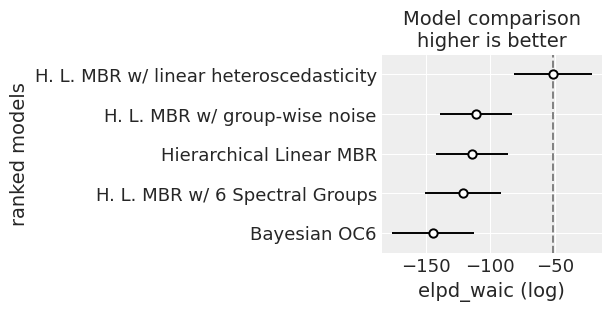

In [278]:
f_comp_waic, ax = pp.subplots(figsize=(6, 3))
az.plot_compare(compare_results_waic, ax=ax)

## MODEL COMPARISON

##### WAIC table interpretation

| Metric      | Description                                                  | Interpretation                                                                     |
| ----------- | ------------------------------------------------------------ | ---------------------------------------------------------------------------------- |
| `rank`      | Model ranking by WAIC (lower WAIC = better)                  | Rank 0 (Hierarchical Linear MBR) is best                                           |
| `elpd_waic` | Expected log pointwise predictive density (higher is better) | -113.81 vs -144.64 → Hierarchical model has better predictive fit                  |
| `p_waic`    | Effective number of parameters                               | 9.65 vs 5.51 → Hierarchical model is more flexible (higher complexity)             |
| `elpd_diff` | Difference in ELPD relative to best model                    | 0 for the best model, 30.82 lower for OC6 → OC6 is worse by \~31 units             |
| `weight`    | Model weight from WAIC-based stacking (sums to 1)            | 0.61 vs 0.39 → 61% probability that the hierarchical model is better               |
| `se`        | Standard error of `elpd_waic`                                | Wide uncertainty (\~28–32), so interpret modest differences with caution           |
| `dse`       | Standard error of `elpd_diff`                                | \~17.4 → the elpd\_diff of 30.82 is \~1.77 × this value (approaching significance) |
| `warning`   | Whether WAIC diagnostics flagged instability                 | `False` for both = no numerical issues                                             |
| `scale`     | The log scale is used (log predictive density)               | Correct for continuous outcome models                                              |


### Empirical Chlorophyll Index Analysis and Mechanistic Interpretation

The empirical feature defined as:

$$
\log_{10}(\text{Rrs}_{555} \times \text{Rrs}_{670}) - \log_{10}(\text{Rrs}_{489} \times \text{Rrs}_{510})
$$

is equivalent to:

$$
\log_{10}\left(\frac{\text{Rrs}_{555} \cdot \text{Rrs}_{670}}{\text{Rrs}_{489} \cdot \text{Rrs}_{510}}\right)
$$

This expression can be interpreted as the contrast between green and red reflectance (numerator) and blue-to-blue-green reflectance (denominator), both of which are strongly shaped by phytoplankton pigment absorption and water optical properties.

#### Spectral Interpretation

* **Rrs\$*{489}\$ and Rrs\$*{510}\$**: These blue and blue-green bands are strongly absorbed by chlorophyll-a and colored dissolved organic matter (CDOM), causing Rrs to decrease as chlorophyll increases.
* **Rrs$\_{555}\$**: Green reflectance tends to remain relatively stable with moderate increases in chlorophyll, serving as a reliable contrast point.
* **Rrs$\_{670}\$**: This red band is minimally reflective in clear water due to strong absorption by both water and chlorophyll. However, in productive waters with high chlorophyll, Rrs$\_{670}\$ increases due to backscattering and fluorescence effects.

#### Why the Index Increases with Chlorophyll

As chlorophyll increases:

* The **denominator** (Rrs\$*{489}\$ \* Rrs\$*{510}\$) decreases due to stronger blue absorption.
* The **numerator** (Rrs\$*{555}\$ \* Rrs\$*{670}\$) increases slightly or stays stable due to sustained green reflectance and increased red reflectance from backscatter.
* Thus, the ratio increases, and so does its log, resulting in a feature that tracks chlorophyll concentration in a log-linear fashion.

#### Explaining Variance at High Index Values

At high chlorophyll or in optically complex (Case-2) waters:

* **CDOM** or **non-algal particles** can suppress blue bands independently of chlorophyll.
* **Suspended sediments** can elevate green and red bands, inflating the index without a corresponding increase in chlorophyll.
* **Backscattering efficiency** varies across phytoplankton types and co-occurring particles, causing spectral variance.
* **Sensor noise** at Rrs$\_{670}\$ (often weak in clear water) can introduce additional uncertainty.

This accounts for the observed increased spread in chlorophyll values at higher index levels.

#### Related Indices in the Literature

This feature shares conceptual foundations with:

* **OCx algorithms**: Blue-to-green band ratios used to empirically estimate chlorophyll \[@oreilly1998].
* **Color Index (CI)**: A three-band index involving 443, 555, and 670 nm used for low-chlorophyll retrievals \[@hu2012novel].
* **NDCI and red/NIR indices**: Used in turbid and high-Chl waters to capture chlorophyll signal where blue bands saturate \[@mishra2012ndci].
* **Optically shallow and complex waters**: The index behavior under high biomass and sediment conditions is consistent with findings in coastal and estuarine waters, such as those explored by Cannizzaro and Carder \[@cannizzaro2006case2].

By blending blue suppression with red enhancement, the index reflects the shift in water-leaving reflectance from oligotrophic to eutrophic conditions.

#### Grouping by Spectral Dominance in Hierarchical Modeling

An expanded version of the grouping approach considers the maximum Rrs value across all key spectral bands—blue, green, and red—to define group membership. This method reflects the dominant optical signal in each observation, which often corresponds to different water types or biogeophysical regimes:

* **Rrs$\_{411}\$-dominant**: Typically associated with ultra-clear, oligotrophic waters. High reflectance at this wavelength implies minimal absorption by both phytoplankton and CDOM, suggesting extremely low pigment concentration and low scattering.
* **Rrs$\_{443}\$-dominant**: Often found in moderately clear Case-1 waters where phytoplankton absorption is just beginning to affect the spectrum. This group may indicate the presence of picoplankton or lightly productive systems.
* **Rrs$\_{489}\$-dominant**: Represents more productive Case-1 waters with moderate phytoplankton biomass. Reflectance here implies a stronger blue signal retained due to a balance of absorption and scattering.
* **Rrs$\_{510}\$-dominant**: Reflects water with increasing influence from particulate scattering, often signaling turbid phytoplankton-rich environments or transitions to Case-2 water.
* **Rrs$\_{555}\$-dominant**: Green-dominant spectra are typically found in high biomass or sediment-rich waters. This group often indicates substantial backscatter, either from large phytoplankton or inorganic particles.
* **Rrs$\_{670}\$-dominant**: Extremely rare but potentially indicative of intense algal blooms or red-dominated turbid waters. Elevated Rrs$\_{670}\$ typically occurs only when backscatter is exceptionally high, and may also reflect chlorophyll fluorescence peaks.

Using this expanded spectral dominance scheme as a hierarchical grouping variable enables the model to learn distinct relationships between the empirical index and chlorophyll concentration that correspond to different optical regimes. Even if there is overlap in the scatter of individual data points across groups, systematic differences in slope or intercept—common across these spectral classes—justify the use of group-specific structure.
In a Bayesian modeling framework, it is often beneficial to introduce hierarchical structure based on meaningful groupings. One such grouping in the context of this index is based on which blue or blue-green band (Rrs\$*{411}\$, Rrs\$*{443}\$, Rrs\$*{489}\$, Rrs\$*{510}\$) is dominant in a given observation. This grouping corresponds to the maximum band used in the numerator of traditional MBR formulations and can reflect underlying optical regimes:

* A dominant Rrs\$*{411}\$ or Rrs\$*{443}\$ may suggest low CDOM and clearer waters.
* A dominant Rrs\$*{489}\$ or Rrs\$*{510}\$ may indicate scattering-dominated or more productive waters.

These spectral signatures can influence the shape and scale of the index–chlorophyll relationship. A hierarchical model allows for varying intercepts and slopes across these groups, capturing inter-group differences while sharing strength through partial pooling. This approach maintains flexibility without overfitting—especially in a Bayesian framework where priors regularize parameter estimates.

By modeling the index components separately (e.g., \$\log\_{10}(\text{Rrs}*{555} \cdot \text{Rrs}*{670})\$ and \$\log\_{10}(\text{Rrs}*{489} \cdot \text{Rrs}*{510})\$) and allowing their coefficients to vary by spectral group, one can better reflect the nonlinear, process-informed relationships observed in ocean color data.

It is also worth noting that while Bayesian hierarchical models can technically accommodate groups with very few observations—thanks to partial pooling and prior regularization—practical utility should guide whether to include such groups. For instance, if only two observations exhibit dominant Rrs$\_{670}\$, the question is whether that group represents a meaningful optical class or merely reflects noise or edge conditions. In such cases, it may be better to collapse the group into a broader category (e.g., red-dominant), or retain it only if its spectral signature is supported by mechanistic understanding.

### References

```bibtex
@article{oreilly1998,
  title={Ocean color chlorophyll algorithms for SeaWiFS},
  author={O'Reilly, John E. and others},
  journal={Journal of Geophysical Research: Oceans},
  volume={103},
  number={C11},
  pages={24937--24953},
  year={1998},
  publisher={Wiley Online Library}
}

@article{hu2012novel,
  title={A novel ocean color index to detect surface phytoplankton blooms},
  author={Hu, Chuanmin and Lee, Zhongping and Franz, Bryan},
  journal={Geophysical Research Letters},
  volume={39},
  number={1},
  year={2012},
  publisher={Wiley Online Library},
  doi={10.1029/2011GL049034}
}

@article{mishra2012ndci,
  title={Normalized difference chlorophyll index: A novel model for remote estimation of chlorophyll-a concentration in turbid productive waters},
  author={Mishra, Sushil and Mishra, DR},
  journal={Remote Sensing of Environment},
  volume={117},
  pages={394--406},
  year={2012},
  publisher={Elsevier},
  doi={10.1016/j.rse.2011.10.016}
}

@article{cannizzaro2006case2,
  title={Case 2 chlorophyll-a retrieval in Southwest Florida coastal waters: a comparison of MODIS and SeaWiFS algorithms},
  author={Cannizzaro, Jennifer P and Carder, Kendall L},
  journal={Remote Sensing of Environment},
  volume={101},
  number={1},
  pages={13--27},
  year={2006},
  publisher={Elsevier},
  doi={10.1016/j.rse.2005.12.002}
}
```


In [ ]:
X2 = np.log10(df.Rrs670 / df.Rrs411) + np.log10(df.Rrs555/df.Rrs489)

### BART Model

In [ ]:
with pm.Model(coords=COORDS) as tree_model_1:
    #Rrs_data = pm.Data('Rrs_std', dx_s, dims=['obs_id', 'bands'])
    σ = pm.Exponential("σ", 1)
    μ = pb.BART('μ', , Y=df_training.log_chl, m=60)
    lkl = pm.Normal('likelihood', mu=μ, sigma=σ, observed=df_training.log_chl, dims='obs_id')

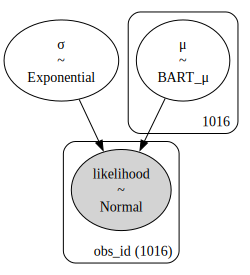

In [15]:
tree_model_1.to_graphviz()

In [16]:
with tree_model_1:
    idata = pm.sample_prior_predictive()

Sampling: [likelihood, μ, σ]


<Axes: xlabel='likelihood'>

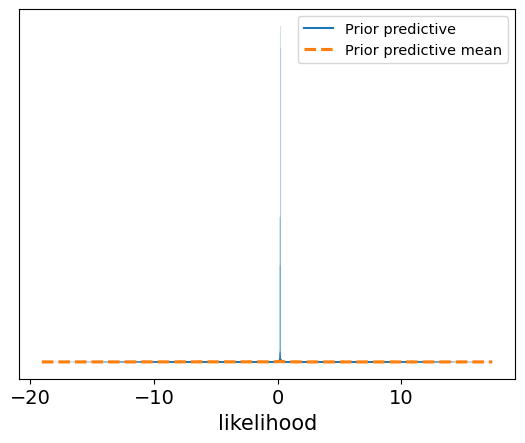

In [17]:
az.plot_ppc(idata, group='prior')

In [18]:
with tree_model_1:
    idata.extend(pm.sample(pgbart={"num_particles": 30, "batch":(0.3, 0.2)}, target_accept=0.95))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 115 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

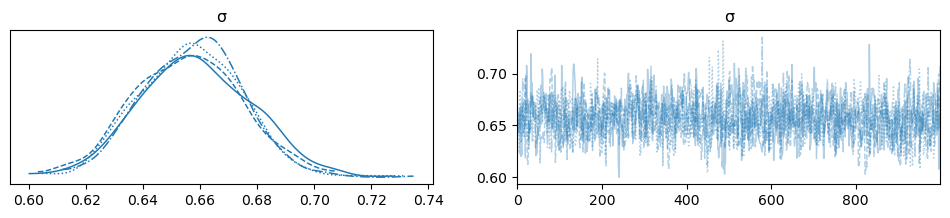

In [20]:
az.plot_trace(idata, var_names=["σ"])

In [159]:
az.summary(idata).r_hat.value_counts()

r_hat
1.00    857
1.01    160
Name: count, dtype: int64

In [ ]:
az.to_netcdf()

In [21]:
with tree_model_1:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [likelihood]


Output()

<Axes: xlabel='likelihood'>

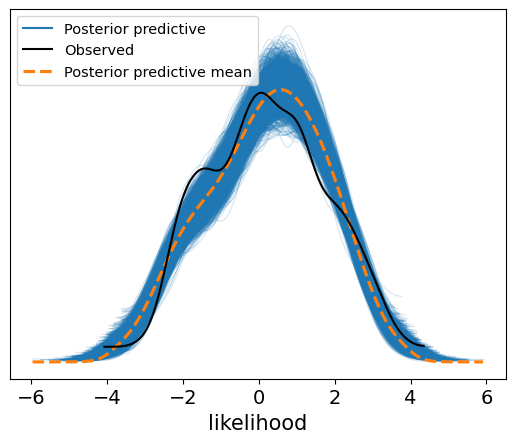

In [22]:
az.plot_ppc(idata)

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/arviz/plots/ecdfplot.py:298: BehaviourChangeWarning: In future versions, if `eval_points` is not provided, then the ECDF will be evaluated at the unique values of the sample. To keep the current behavior, provide `eval_points` explicitly.
  warnings.warn(


array([<Axes: xlabel='ESS'>, <Axes: xlabel='R-hat'>], dtype=object)

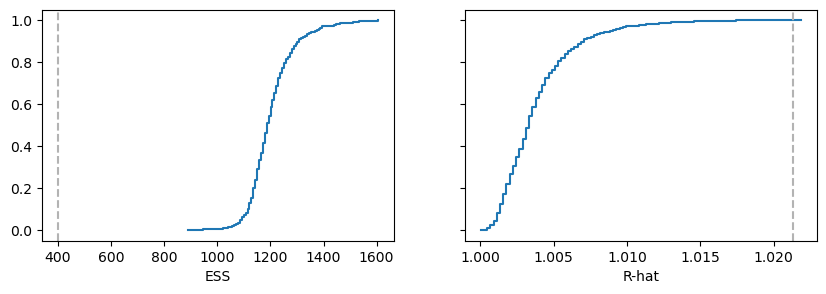

In [23]:
pb.plot_convergence(idata, var_name="μ")

In [26]:
az.summary(idata, var_names='σ')

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
σ  0.657  0.018   0.624    0.691      0.001      0.0     970.0    1676.0   

   r_hat  
σ    1.0

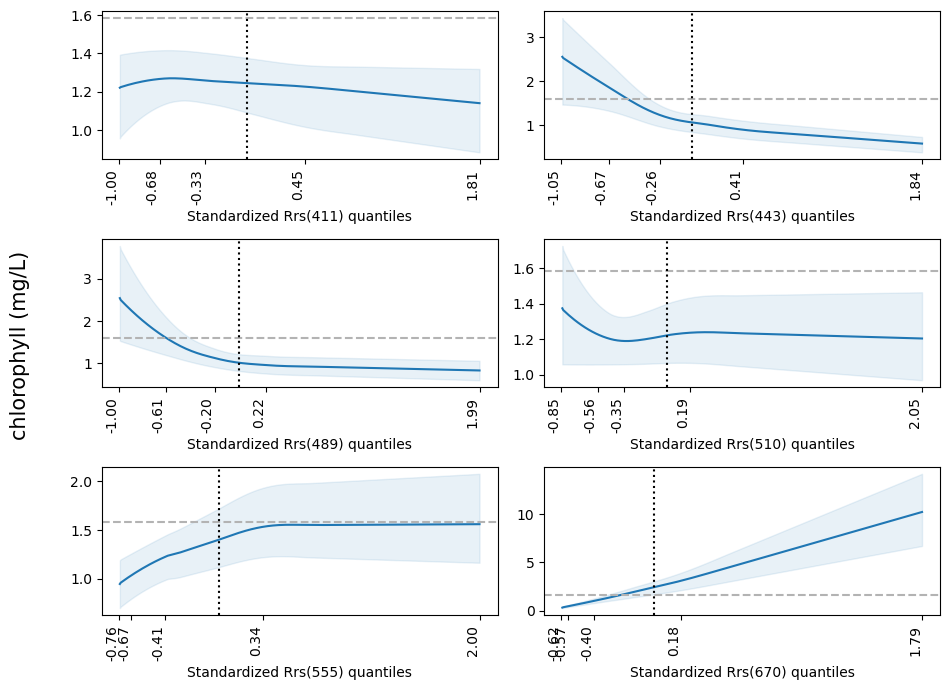

In [27]:
# Access the bartrv
bart_rv = tree_model_1.named_vars['μ']
f, axs = pp.subplots(nrows=3, ncols=2, figsize=(9, 7))
# Now you can use plot_pdp
quantiles_to_use = [0.05, 0.25, 0.5, 0.75, 0.95]
pb.plot_pdp(
    bart_rv, X=dx_s, Y=log_dy, #grid=(3, 2), figsize=(6, 8)
    func=np.exp, 
    ax=axs.flatten(), 
    xs_interval='quantiles',
    xs_values=quantiles_to_use
    )
for ax in axs.flatten():
    # Get the quantile values for the current feature
    current_feature_name = ax.get_xlabel()
    current_quantile_values = dx_s[current_feature_name].quantile(quantiles_to_use).values

    # Format Xlabels
    label = ax.get_xlabel()
    ax.set_xlabel(label.replace('rrs', 'Standardized Rrs(').replace('_s', ') quantiles'))
    # Set the x-axis ticks and labels
    ax.set_xticks(current_quantile_values)
    ax.set_xticklabels([f'{q:.2f}' for q in current_quantile_values], rotation=90, ha="right")
    ax.axvline(0, ls=':', color='k')

y_label_text = f.get_children()[-1]
y_label_text.set_text('chlorophyll (mg/L)')
f.tight_layout()

Figure X: Partial Dependence of Predicted Marine Chlorophyll a Concentration on Standardized Remote Sensing Reflectance (Rrs) at Six Wavelengths. Each subplot displays the partial dependence of the predicted chlorophyll a concentration (Chl-a, g/m³) on the standardized remote sensing reflectance (Rrs, sr⁻¹) at the indicated wavelength (411, 443, 489, 510, 555, and 670 nm). The solid line represents the mean partial dependence, and the shaded area indicates the uncertainty around these estimates. The dashed horizontal line denotes the average predicted Chl-a concentration across the entire dataset. The vertical dashed line at 0 on the x-axis indicates the mean standardized Rrs value. The plots reveal varied and non-linear relationships between reflectance at different wavelengths and predicted Chl-a, with some wavelengths showing suppressive effects (e.g., 411 nm), others exhibiting transitions across the average prediction (e.g., 443, 489 nm), and some showing primarily positive (e.g., 555, 670 nm) or negative (e.g., 510 nm) associations relative to the overall mean prediction. The approximate quantiles mentioned in the main text provide context for the standardized Rrs values on the x-axis.

### <u>Interpretation of Partial Dependence Plots</u>:
These partial dependence plots offer insights into how changes in remote sensing reflectance (Rrs) at specific wavelengths influence the predicted concentration of marine chlorophyll a (Chl-a), relative to the average prediction across all conditions.

* Rrs(411 nm): The consistent position below the reference line suggests that higher reflectance at 411 nm is generally associated with lower predicted Chl-a concentrations compared to the average. The slight initial increase up to the 25th percentile of standardized Rrs(411) (-0.68) indicates a potential minor positive influence at lower reflectance values, but beyond this point, increasing Rrs(411) strongly correlates with a decrease in predicted Chl-a.

* Rrs(443 nm): Starting above the average prediction, higher reflectance at 443 nm is linked to lower predicted Chl-a. The crossing of the reference line between the 25th and 50th percentiles of standardized Rrs(443) indicates a transition point. Below this range, higher Rrs(443) is associated with above-average Chl-a predictions, while above this range, it's associated with below-average predictions. This suggests a complex, potentially saturating relationship.

* Rrs(489 nm): The strong initial negative slope from above the reference line indicates that increasing reflectance at 489 nm is a strong predictor of lower Chl-a concentrations, particularly at lower Rrs(489) values. The crossing of the reference line just past the 25th percentile suggests that beyond this relatively low reflectance, Rrs(489) is associated with below-average Chl-a. The subsequent inflection point and reduced slope indicate a diminishing negative impact of further increases in Rrs(489).

* Rrs(510 nm): Reflectance at 510 nm consistently predicts below-average Chl-a concentrations. The initial negative slope indicates that higher Rrs(510) is associated with lower Chl-a. The inflection point around the 50th percentile marks a shift to a slight positive relationship with Chl-a, although predictions remain below average until Rrs(510) crosses the standardized mean (0). Beyond this point, the relationship flattens, suggesting that very high Rrs(510) has a minimal impact on the predicted Chl-a, albeit still generally below the overall average.

* Rrs(555 nm): Starting below the average prediction, increasing reflectance at 555 nm is associated with higher predicted Chl-a. The PDP joins the reference line around the 75th percentile of standardized Rrs(555), suggesting that beyond this relatively high reflectance, Rrs(555) has little further influence on the predicted Chl-a, remaining close to the average prediction.

* Rrs(670 nm): The consistent upward slope indicates a positive correlation between Rrs(670) and predicted Chl-a across the observed range. Starting below the average, the PDP crosses the reference line shortly after the 75th percentile, suggesting that only at relatively high Rrs(670) values are predictions above the overall average. The widening uncertainty envelope at higher Rrs(670) suggests greater model uncertainty in this range.

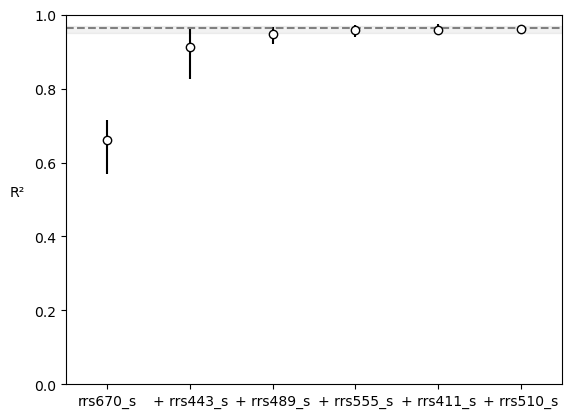

In [28]:
vi_results = pb.compute_variable_importance(idata, bartrv=bart_rv, X=dx_s)
f, ax = pp.subplots()
pb.plot_variable_importance(vi_results, ax=ax, );
#ax.set_xticklabels(ax)

#### 2. Log-transformed data

In [29]:
with pm.Model(coords=coords) as tree_model_2:
    Rrs_data = pm.Data('Rrs', log_dx, dims=['obs_id', 'bands'])
    Log_chl = pm.Data('Log_chl', log_dy, dims='obs_id')
    σ = pm.Exponential("σ", 1)
    μ = pb.BART('μ', X=Rrs_data, Y=Log_chl, m=60)
    lkl = pm.Normal('likelihood', mu=μ, sigma=σ, observed=Log_chl, dims='obs_id')

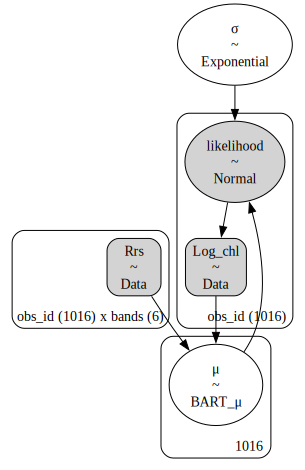

In [30]:
tree_model_2.to_graphviz()

In [31]:
with tree_model_2:
    idata2 = pm.sample_prior_predictive()

Sampling: [likelihood, μ, σ]


In [32]:
with tree_model_2:
    idata2.extend(pm.sample())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [33]:
with tree_model_2:
    idata2.extend(pm.sample_posterior_predictive(idata2))

Sampling: [likelihood]


Output()

<Axes: xlabel='likelihood'>

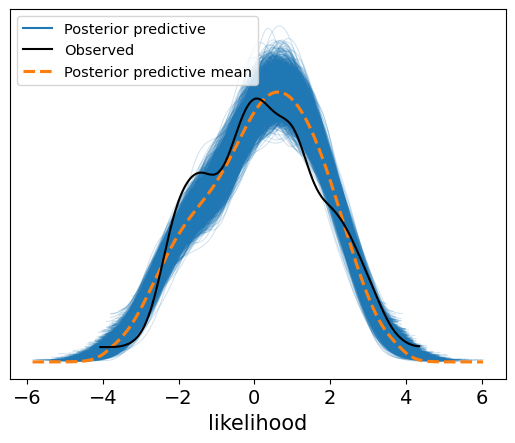

In [34]:
az.plot_ppc(idata2)

#### 3. Band Ratio Data

In [123]:
dx_br

rrs411    rrs443    rrs489    rrs510    rrs670
index                                                  
0      0.161033  0.225436  0.440300  0.539676  0.463226
1      0.255705  0.333332  0.523333  0.601926  0.408199
2      0.228738  0.279226  0.434143  0.538844  0.379752
3      0.210809  0.249399  0.412121  0.524837  0.463187
4      0.323167  0.365028  0.537699  0.679622  0.639316
...         ...       ...       ...       ...       ...
4454   0.354732  0.451564  0.709681  0.774194  0.225730
4455   0.692323  0.730756  0.884823  0.884653  0.192362
4456   1.038690  1.153909  1.423358  1.269328  0.153810
4457   0.467143  0.533671  0.733456  0.799689  0.332989
4458   0.291709  0.375323  0.583477  0.666444  0.291528

[1016 rows x 5 columns]

In [35]:
bands = [i[-6:] for i in dx_br.columns]

coords = {
    'bands': bands,
    'obs_id': df_log.index}

In [36]:
bands

['rrs411', 'rrs443', 'rrs489', 'rrs510', 'rrs670']

In [44]:
with pm.Model(coords=coords) as tree_model_3:
    Rrs_data = pm.Data('Rrs', dx_br, dims=['obs_id', 'bands'])
    Log_chl = pm.Data('Log_chl', log_dy, dims='obs_id')
    σ = pm.Exponential("σ", 1)
    μ = pb.BART('μ', X=Rrs_data, Y=Log_chl, m=60)
    lkl = pm.Normal('likelihood', mu=μ, sigma=σ, observed=Log_chl, dims='obs_id')

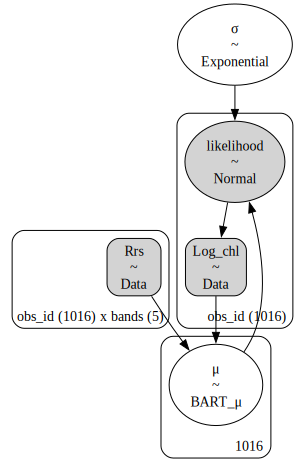

In [45]:
tree_model_3.to_graphviz()

In [46]:
with tree_model_3:
    idata3 = pm.sample_prior_predictive()
    idata3.extend(pm.sample())
    idata3.extend(pm.sample_posterior_predictive(idata3))

Sampling: [likelihood, μ, σ]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

<Axes: xlabel='likelihood'>

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


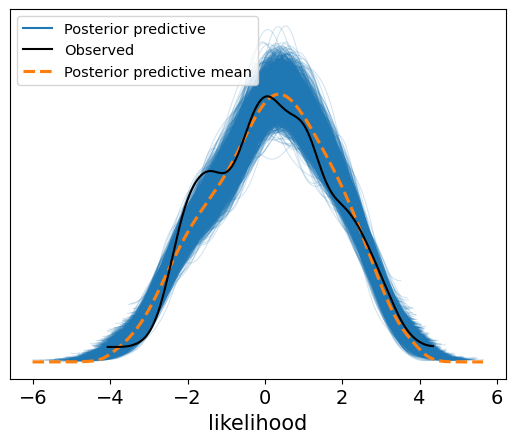

In [48]:
az.plot_ppc(idata3)

In [51]:
with tree_model_1:
  ll_tm1 =  pm.compute_log_likelihood(idata)

Output()

In [52]:
with tree_model_2:
    ll_tm2 = pm.compute_log_likelihood(idata2)

with tree_model_3:
    ll_tm3 = pm.compute_log_likelihood(idata3)

Output()

Output()

In [53]:
compare_results = az.compare(
    {'standardized' :ll_tm1, 'log(Rrs)':ll_tm2, 'band ratio':ll_tm3}, ic='loo'
)

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


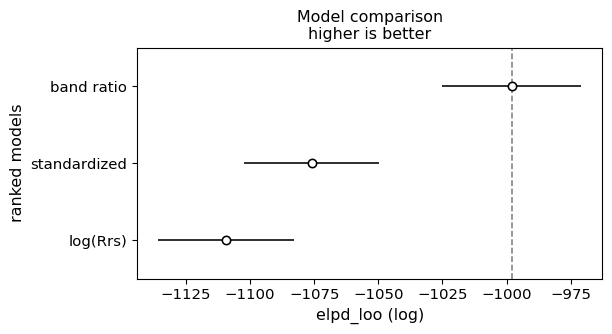

In [57]:
ax = az.plot_compare(compare_results)

### 4. Log-transformed band ratio data

In [58]:
dx_log_br = np.log(dx_br)

In [59]:
dx_log_br

rrs411    rrs443    rrs489    rrs510    rrs670
index                                                  
0     -1.826143 -1.489719 -0.820299 -0.616786 -0.769540
1     -1.363731 -1.098616 -0.647537 -0.507620 -0.895999
2     -1.475178 -1.275735 -0.834381 -0.618329 -0.968237
3     -1.556805 -1.388700 -0.886438 -0.644668 -0.769624
4     -1.129585 -1.007782 -0.620457 -0.386219 -0.447357
...         ...       ...       ...       ...       ...
4454  -1.036393 -0.795039 -0.342940 -0.255932 -1.488418
4455  -0.367703 -0.313676 -0.122367 -0.122560 -1.648374
4456   0.037961  0.143155  0.353019  0.238488 -1.872036
4457  -0.761120 -0.627975 -0.309988 -0.223532 -1.099645
4458  -1.231999 -0.979967 -0.538751 -0.405800 -1.232619

[1016 rows x 5 columns]

In [60]:
bands = [i[-6:] for i in dx_log_br.columns]

coords = {
    'bands': bands,
    'obs_id': df_log.index}

In [61]:
with pm.Model(coords=coords) as tree_model_4:
    Rrs_data = pm.Data('Rrs', dx_log_br, dims=['obs_id', 'bands'])
    Log_chl = pm.Data('Log_chl', log_dy, dims='obs_id')
    σ = pm.Exponential("σ", 1)
    μ = pb.BART('μ', X=Rrs_data, Y=Log_chl, m=60)
    lkl = pm.Normal('likelihood', mu=μ, sigma=σ, observed=Log_chl, dims='obs_id')

In [62]:
with tree_model_4:
    idata4 = pm.sample_prior_predictive()
    idata4.extend(pm.sample())
    idata4.extend(pm.sample_posterior_predictive(idata4))

Sampling: [likelihood, μ, σ]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [σ]
>PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

In [63]:
with tree_model_4:
    ll_tm4 = pm.compute_log_likelihood(idata4)

Output()

#### 5. OC4 algorithm:

In [67]:
dx_br

rrs411    rrs443    rrs489    rrs510    rrs670
index                                                  
0      0.161033  0.225436  0.440300  0.539676  0.463226
1      0.255705  0.333332  0.523333  0.601926  0.408199
2      0.228738  0.279226  0.434143  0.538844  0.379752
3      0.210809  0.249399  0.412121  0.524837  0.463187
4      0.323167  0.365028  0.537699  0.679622  0.639316
...         ...       ...       ...       ...       ...
4454   0.354732  0.451564  0.709681  0.774194  0.225730
4455   0.692323  0.730756  0.884823  0.884653  0.192362
4456   1.038690  1.153909  1.423358  1.269328  0.153810
4457   0.467143  0.533671  0.733456  0.799689  0.332989
4458   0.291709  0.375323  0.583477  0.666444  0.291528

[1016 rows x 5 columns]

In [ ]:
# preprocessing:

def compute_max_ratio_OC4(row):
    # Create a dictionary of ratios for each band.
    ratios = {'443': row['rrs443'], '489': row['rrs489'], '510': row['rrs510']}
    # Identify the band that has the maximum ratio.
    band_used = max(ratios, key=ratios.get)
    return pd.Series({'R': ratios[band_used], 'band_used': band_used})

# Copy the original DataFrame and compute the maximum ratio and the corresponding band.
d_oc4 = dx_br.copy()
d_oc4[['R', 'band_used']] = d_ocx.apply(compute_max_ratio_OC4, axis=1)
# Compute the log10 of the maximum ratio and the log10 of chlorophyll.
d_oc4['logR'] = np.log10(d_ocx['R'])

# (Optional) Check a few rows to see which band was selected:
print(d_oc4[['R', 'band_used', 'logR']].head())

              R band_used      logR
index                              
0      0.539676       510 -0.267867
1      0.601926       510 -0.220457
2      0.538844       510 -0.268537
3      0.524837       510 -0.279976
4      0.679622       510 -0.167733


In [70]:
with pm.Model() as model_ocx:
    # Priors for the polynomial regression coefficients
    a0 = pm.Normal("a0", mu=0, sigma=10)
    a1 = pm.Normal("a1", mu=0, sigma=10)
    a2 = pm.Normal("a2", mu=0, sigma=10)
    a3 = pm.Normal("a3", mu=0, sigma=10)
    a4 = pm.Normal("a4", mu=0, sigma=10)
    
    # Expected log(chlorophyll) as a fourth-order polynomial function of logR
    mu = (a0 +
          a1 * d_ocx["logR"].values +
          a2 * d_ocx["logR"].values**2 +
          a3 * d_ocx["logR"].values**3 +
          a4 * d_ocx["logR"].values**4)
    
    # Likelihood: assume normally distributed errors in log space
    sigma = pm.HalfNormal("sigma", sigma=1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=log_dy)
    

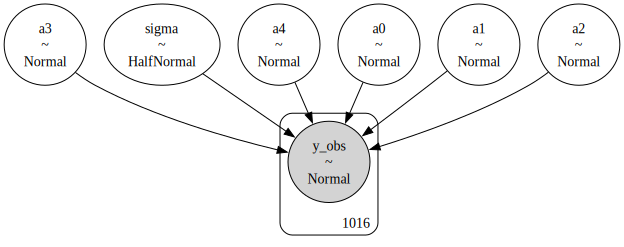

In [71]:
model_ocx.to_graphviz()

In [72]:
with model_ocx:
    idata_ocx = pm.sample_prior_predictive()
    idata_ocx.extend(pm.sample())
    idata_ocx.extend(pm.sample_posterior_predictive(idata_ocx))

Sampling: [a0, a1, a2, a3, a4, sigma, y_obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, a1, a2, a3, a4, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Sampling: [y_obs]


Output()

In [74]:
with model_ocx:
    ll_ocx = pm.compute_log_likelihood(idata_ocx)

Output()

<Axes: xlabel='y_obs'>

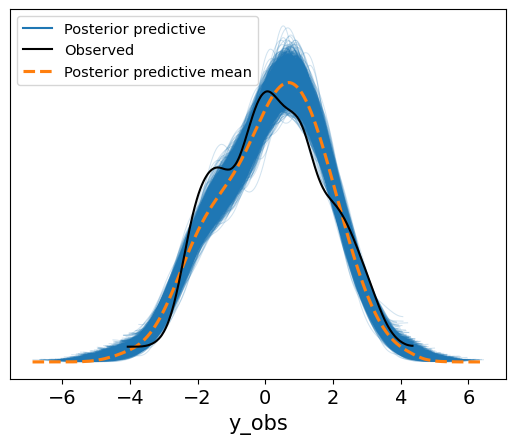

In [170]:
az.plot_ppc(idata_ocx)

### 6 CI/OCI

In [77]:
# Compute the CI value using Hu et al.'s formulation:
# CI = Rrs(555) - [ Rrs(443) + (555-443)/(670-443) * (Rrs(670) - Rrs(443)) ]
df_ci = dx.copy()
weight = (555 - 443) / (670 - 443)
df_ci['CI'] = df_ci['rrs555'] - (df_ci['rrs443'] + weight * (df_ci['rrs670'] - df_ci['rrs443']))

# (Optional) Inspect the computed CI and logChl values
print(df_ci.head())

         rrs411    rrs443    rrs489    rrs510    rrs555    rrs670        CI
index                                                                      
0      0.001204  0.001686  0.003293  0.004036  0.007479  0.003465  0.004916
1      0.001062  0.001384  0.002173  0.002499  0.004152  0.001695  0.002615
2      0.000971  0.001185  0.001843  0.002288  0.004246  0.001612  0.002850
3      0.001472  0.001741  0.002877  0.003664  0.006982  0.003234  0.004504
4      0.000905  0.001022  0.001506  0.001903  0.002801  0.001791  0.001399


In [78]:
with pm.Model() as model_ci:
    # Priors for the regression coefficients
    a = pm.Normal("a", mu=0, sigma=10)
    b = pm.Normal("b", mu=0, sigma=10)
    
    # Expected log(chlorophyll) as a linear function of CI
    mu = a + b * df_ci["CI"].values
    
    # Likelihood: assume normally distributed errors
    sigma = pm.HalfNormal("sigma", sigma=1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=log_dy)

In [79]:
with model_ci:
    idata_ci = pm.sample_prior_predictive()
    idata_ci.extend(pm.sample())
    idata_ci.extend(pm.sample_posterior_predictive(idata_ci))


Sampling: [a, b, sigma, y_obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y_obs]


Output()

In [80]:
with model_ci:
    ll_ci = pm.compute_log_likelihood(idata_ci)

Output()

In [85]:
# --- Combine into one DataFrame for OCI ---
df_oci = pd.DataFrame({
    'logR': d_ocx['logR'],
    'CI': df_ci['CI']  # observed log-chlorophyll
})

# Define thresholds (in physical units, mg m^-3) for the hybrid algorithm:
Chl_L = 0.25  # lower threshold
Chl_H = 0.4   # upper threshold

In [86]:
import pytensor.tensor as pt

In [ ]:

# Assume df_oci is prepared as before with columns: 'logR', 'CI', 'logChl'
Chl_L = 0.25  # lower threshold in physical units
Chl_H = 0.4   # upper threshold

with pm.Model() as model_oci:
    # --- CI Component ---
    a = pm.Normal("a", mu=0, sigma=10)
    b = pm.Normal("b", mu=0, sigma=10)
    logChl_CI = a + b * df_oci["CI"].values
    # Work in log-space for stability:
    # So we define logChl_CI (and do not convert it back to physical units immediately)
    
    # --- OCx Component ---
    a0 = pm.Normal("a0", mu=0, sigma=10)
    a1 = pm.Normal("a1", mu=0, sigma=10)
    a2 = pm.Normal("a2", mu=0, sigma=10)
    a3 = pm.Normal("a3", mu=0, sigma=10)
    a4 = pm.Normal("a4", mu=0, sigma=10)
    logR = df_oci["logR"].values
    logChl_OCx = a0 + a1 * logR + a2 * (logR**2) + a3 * (logR**3) + a4 * (logR**4)
    
    # Instead of using hard switching on the physical units,
    # we compute the predicted chlorophyll in log-space for both branches.
    # Convert thresholds to log-space:
    logChl_L = np.log10(Chl_L)
    logChl_H = np.log10(Chl_H)
    
    # Smoothly blend the two predictions using a logistic function.
    # Define a transition parameter (steepness of the logistic)
    k = 20  # larger k means a sharper transition
    # Compute a weight based on the CI branch prediction:
    w = 1 / (1 + pt.exp(-k * (logChl_CI - logChl_L)))  # weight for CI branch
    # Similarly, you could blend between the two when CI branch is in [logChl_L, logChl_H]
    # For simplicity, we blend across the entire range:
    pred_logChl = w * logChl_CI + (1 - w) * logChl_OCx
    
    sigma = pm.HalfNormal("sigma", sigma=1)
    y_obs = pm.Normal("y_obs", mu=pred_logChl, sigma=sigma, observed=log_dy.values)
    

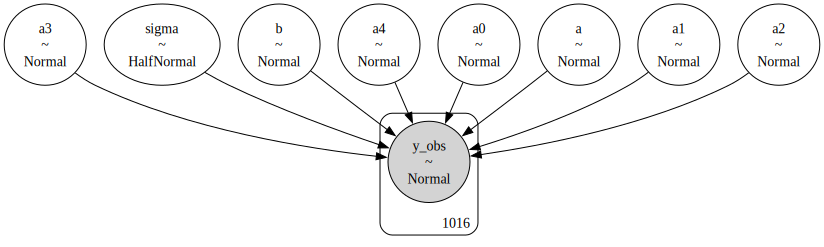

In [117]:
model_oci.to_graphviz()

In [118]:
with model_oci:
    idata_oci = pm.sample_prior_predictive()
    idata_oci.extend(pm.sample(target_accept=0.95))
    idata_oci.extend(pm.sample_posterior_predictive(idata_oci))

Sampling: [a, a0, a1, a2, a3, a4, b, sigma, y_obs]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, a0, a1, a2, a3, a4, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_obs]


Output()

In [119]:
with model_oci:
    ll_oci = pm.compute_log_likelihood(idata_oci)

Output()

In [131]:
fc.tight_layout()
fc.savefig('test.png', dpi=300)

In [132]:
ax.get_title()

'Model comparison\nhigher is better'

### 7 OC5

In [151]:
# preprocessing:

def compute_max_ratio_OC5(row):
    # Create a dictionary of ratios for each band.
    ratios = {
        '411': row['rrs411'], '443': row['rrs443'], 
        '489': row['rrs489'], '510': row['rrs510']}
    # Identify the band that has the maximum ratio.
    band_used = max(ratios, key=ratios.get)
    return pd.Series({'R': ratios[band_used], 'band_used': band_used})

# Copy the original DataFrame and compute the maximum ratio and the corresponding band.
d_oc5 = dx_br.copy()
d_oc5[['R', 'band_used']] = d_oc5.apply(compute_max_ratio_OC5, axis=1)
# Compute the log10 of the maximum ratio and the log10 of chlorophyll.
d_oc5['logR'] = np.log10(d_oc5['R'])

# (Optional) Check a few rows to see which band was selected:
print(d_oc5[['R', 'band_used', 'logR']].head())

              R band_used      logR
index                              
0      0.539676       510 -0.267867
1      0.601926       510 -0.220457
2      0.538844       510 -0.268537
3      0.524837       510 -0.279976
4      0.679622       510 -0.167733


In [152]:
d_oc5.band_used.value_counts(normalize=True)

band_used
510    0.501969
411    0.244094
489    0.242126
443    0.011811
Name: proportion, dtype: float64

In [162]:
with pm.Model() as model_oc5:
    # Priors for the polynomial regression coefficients
    a0 = pm.Normal("a0", mu=0, sigma=10)
    a1 = pm.Normal("a1", mu=0, sigma=10)
    a2 = pm.Normal("a2", mu=0, sigma=10)
    a3 = pm.Normal("a3", mu=0, sigma=10)
    a4 = pm.Normal("a4", mu=0, sigma=10)
    
    # Expected log(chlorophyll) as a fourth-order polynomial function of logR
    mu = (a0 +
          a1 * d_oc5["logR"].values +
          a2 * d_oc5["logR"].values**2 +
          a3 * d_oc5["logR"].values**3 +
          a4 * d_oc5["logR"].values**4)
    
    # Likelihood: assume normally distributed errors in log space
    sigma = pm.HalfNormal("sigma", sigma=1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=log_dy)

In [154]:
d_ocx.band_used.value_counts()

band_used
510    523
489    272
443    221
Name: count, dtype: int64

In [155]:
with model_oc5:
    idata_oc5 = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, a1, a2, a3, a4, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [156]:
with model_oc5:
    ll_oc5 = pm.compute_log_likelihood(idata_oc5)

Output()

In [171]:
with model_oc5:
    idata_oc5.extend(
        pm.sample_posterior_predictive(idata_oc5))

Sampling: [y_obs]


Output()

<Axes: xlabel='y_obs'>

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


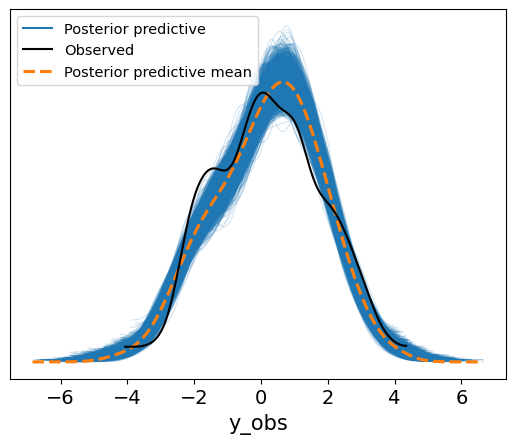

In [172]:
az.plot_ppc(idata_oc5)

### 8. OC6

In [ ]:
dx_br = dx.divide(dx.rrs555, axis=0)
dx_br.drop('rrs555', axis=1, inplace=True)

In [145]:
mean = dx.loc[:,['rrs555', 'rrs670']].mean(axis=1)

In [149]:
dx_br_oc6 = dx.loc[:, ['rrs411', 'rrs443', 'rrs489', 'rrs510']].divide(mean, axis=0)

In [150]:
dx_br_oc6.head()

rrs411    rrs443    rrs489    rrs510
index                                        
0      0.220107  0.308136  0.601821  0.737652
1      0.363166  0.473416  0.743266  0.854888
2      0.331564  0.404747  0.629306  0.781074
3      0.288150  0.340899  0.563320  0.717388
4      0.394271  0.445342  0.656004  0.829153

In [158]:
# preprocessing:

def compute_max_ratio_OC6(row):
    # Create a dictionary of ratios for each band.
    ratios = {
        '411': row['rrs411'], '443': row['rrs443'], 
        '489': row['rrs489'], '510': row['rrs510']}
    # Identify the band that has the maximum ratio.
    band_used = max(ratios, key=ratios.get)
    return pd.Series({'R': ratios[band_used], 'band_used': band_used})

# Copy the original DataFrame and compute the maximum ratio and the corresponding band.
d_oc6 = dx_br_oc6.copy()
d_oc6[['R', 'band_used']] = d_oc6.apply(compute_max_ratio_OC6, axis=1)
# Compute the log10 of the maximum ratio and the log10 of chlorophyll.
d_oc6['logR'] = np.log10(d_oc6['R'])

# (Optional) Check a few rows to see which band was selected:
print(d_oc6[['R', 'band_used', 'logR']].head())

              R band_used      logR
index                              
0      0.737652       510 -0.132148
1      0.854888       510 -0.068091
2      0.781074       510 -0.107308
3      0.717388       510 -0.144246
4      0.829153       510 -0.081365


In [160]:
d_oc6.band_used.value_counts(normalize=True)

band_used
510    0.501969
411    0.244094
489    0.242126
443    0.011811
Name: proportion, dtype: float64

In [163]:
with pm.Model() as model_oc6:
    # Priors for the polynomial regression coefficients
    a0 = pm.Normal("a0", mu=0, sigma=10)
    a1 = pm.Normal("a1", mu=0, sigma=10)
    a2 = pm.Normal("a2", mu=0, sigma=10)
    a3 = pm.Normal("a3", mu=0, sigma=10)
    a4 = pm.Normal("a4", mu=0, sigma=10)
    
    # Expected log(chlorophyll) as a fourth-order polynomial function of logR
    mu = (a0 +
          a1 * d_oc6["logR"].values +
          a2 * d_oc6["logR"].values**2 +
          a3 * d_oc6["logR"].values**3 +
          a4 * d_oc6["logR"].values**4)
    
    # Likelihood: assume normally distributed errors in log space
    sigma = pm.HalfNormal("sigma", sigma=1)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=log_dy)

In [164]:
with model_oc6:
    idata_oc6 = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, a1, a2, a3, a4, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [173]:
with model_oc6:
    idata_oc6.extend(
        pm.sample_posterior_predictive(idata_oc6))

Sampling: [y_obs]


Output()

<Axes: xlabel='y_obs'>

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


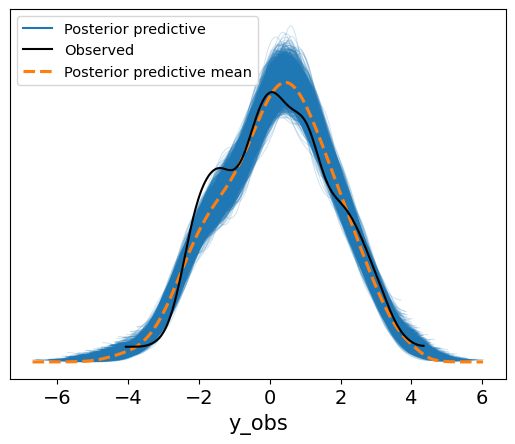

In [174]:
az.plot_ppc(idata_oc6)

In [165]:
with model_oc6:
    ll_oc6 = pm.compute_log_likelihood(idata_oc6)

Output()

/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


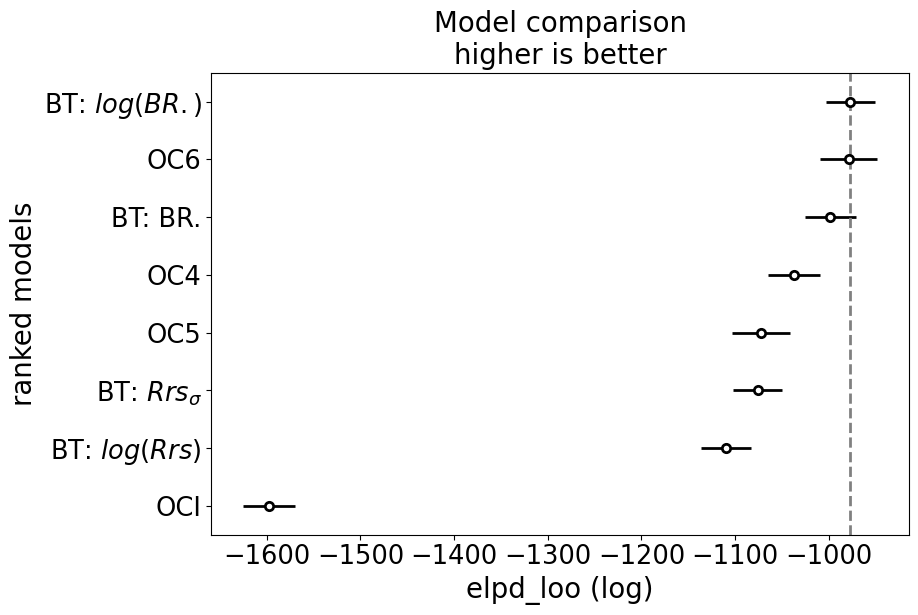

In [166]:
compare_results = az.compare(
    {
        r'BT: $Rrs_σ$' :ll_tm1, r'BT: $log(Rrs)$':ll_tm2, 'BT: BR.':ll_tm3, r'BT: $log(BR.)$': ll_tm4,
        'OC4': ll_ocx, 'OC5': ll_oc5 , 'OC6': ll_oc6, 'OCI': ll_oci
        }, ic='loo'
)
ax = az.plot_compare(compare_results, figsize=(9, 6))
fc = pp.gcf()

In [167]:
fc.tight_layout()
fc.savefig('model_comparison_fig.png', dpi=300)

In [168]:
compare_results.to_parquet('./model_comparison_loo.pqt')

In [169]:
compare_results

rank     elpd_loo       p_loo   elpd_diff        weight  \
BT: $log(BR.)$     0  -976.774014   93.861409    0.000000  3.476905e-01   
OC6                1  -978.515303    5.719789    1.741289  5.773510e-01   
BT: BR.            2  -998.033842  116.113363   21.259828  7.441267e-08   
OC4                3 -1037.006942    5.444256   60.232928  1.545393e-03   
OC5                4 -1072.593546    5.674830   95.819532  8.693036e-08   
BT: $Rrs_σ$        5 -1075.868991  107.144719   99.094977  7.341305e-02   
BT: $log(Rrs)$     6 -1109.403546  128.159159  132.629532  8.238074e-08   
OCI                7 -1597.712003  206.797302  620.937989  0.000000e+00   

                       se        dse  warning scale  
BT: $log(BR.)$  26.579674   0.000000    False   log  
OC6             30.420046  16.445246    False   log  
BT: BR.         27.041790   1.842614     True   log  
OC4             28.163670  18.049240    False   log  
OC5             30.920946  21.762989    False   log  
BT: $Rrs_σ$     26.304131  18.839117    False   log  
BT: $log(Rrs)$  26.373735  18.977165    False   log  
OCI             27.409468  26.291027    False   log